
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2631910/638584088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


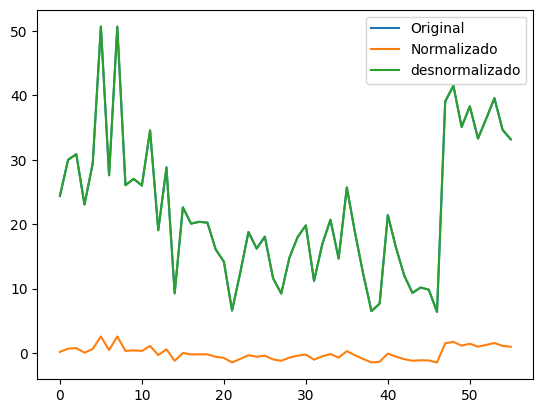

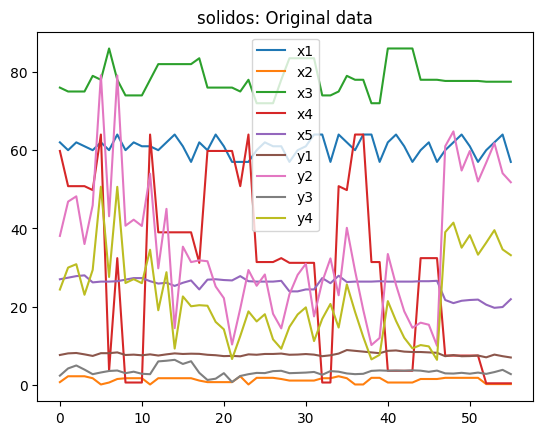

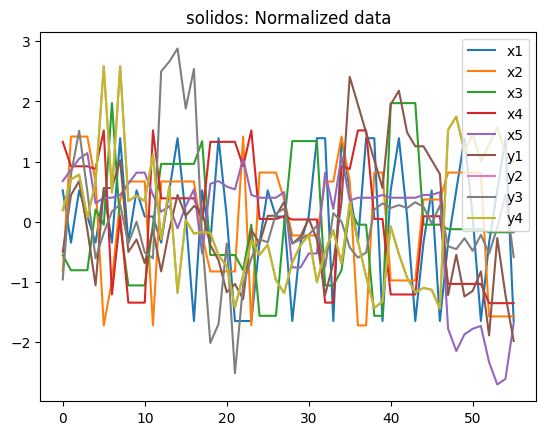

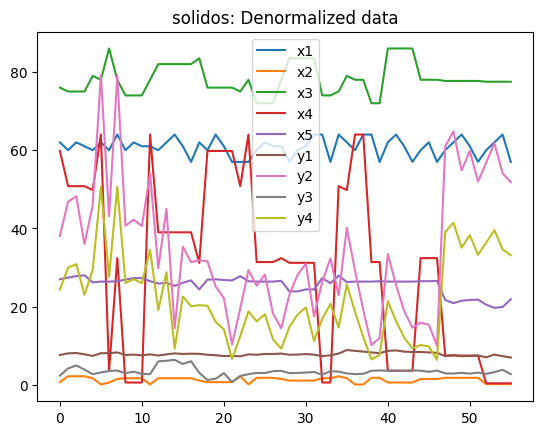

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 00:50:20.511919: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:20.571317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 00:50:20.571365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 00:50:20.572792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 00:50:20.581517: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:20.582485: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.766482265000377
Stopped at epoch:  7
1/1 [==============================] - 0s 40ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.5380578760004937
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.43613665099928767
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.5124420629999804
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.4522053380005673
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.3936919649995616
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_0] | 7 ++++++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.803705,0.615865,0.719477,0.673733,23.673178,41.066504,10.158692,26.521640
model_3_9_15,0.804176,0.432282,-1.552572,0.069590,23.616393,60.692694,92.437268,75.631298
model_3_9_14,0.811994,0.468033,-1.459281,0.114039,22.673583,56.870707,89.058882,72.018108
model_3_9_13,0.820424,0.507543,-1.357223,0.162945,21.656969,52.646857,85.363025,68.042686
model_3_9_12,0.829623,0.551535,-1.243471,0.217422,20.547538,47.943791,81.243669,63.614319
model_3_9_1,0.833143,0.681498,0.611197,0.696730,20.122971,34.049867,14.079873,24.652222
model_3_9_11,0.839841,0.600824,-1.112878,0.279118,19.315251,42.674520,76.514455,58.599199
model_3_9_10,0.851250,0.655370,-0.958741,0.349410,17.939239,36.843165,70.932620,52.885266
model_3_9_2,0.855088,0.734110,0.480077,0.705873,17.476420,28.425351,18.828153,23.909022
model_3_9_9,0.863273,0.711671,-0.779774,0.426129,16.489258,30.824261,64.451645,46.648893


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.552978331000304
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3304262800002107
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3042468960002225
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.290225726999779
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.23128211200037185
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.27986314299960213
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.800624,0.842113,0.642966,0.775171,24.044745,28.345790,36.520387,32.192659
model_5_3_5,0.803930,0.753820,0.208835,0.570619,23.646077,44.197287,80.926985,61.481862
model_5_3_1,0.809634,0.824839,0.566281,0.737925,22.958234,31.447098,44.364372,37.525806
model_5_3_4,0.809932,0.771474,0.303536,0.614174,22.922205,41.027802,71.240114,55.245355
model_5_3_3,0.813399,0.789350,0.395591,0.656986,22.504162,37.818411,61.824029,49.115177
model_5_3_2,0.813583,0.807198,0.483624,0.698428,22.481994,34.614104,52.819227,43.181233


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.35487969299992983
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.2401418890003697
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.3233626399996865
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.3097105229999215
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.29483656199954567
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.28835084599995753
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.371252846

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.801703,0.630111,0.171636,0.584624,23.914717,41.670610,30.774206,36.542898
model_5_4_8,0.802748,0.325111,-0.732112,0.198258,23.788707,76.031011,64.348946,70.533565
model_5_4_7,0.808353,0.361666,-0.624606,0.244404,23.112644,71.912819,60.355014,66.473856
model_5_4_1,0.812257,0.594544,0.072000,0.540712,22.641859,45.677501,34.475726,40.406089
model_5_4_6,0.813300,0.399683,-0.512538,0.292448,22.516065,67.629918,56.191660,62.247215
model_5_4_5,0.817241,0.438763,-0.396673,0.341967,22.040813,63.227264,51.887184,57.890771
model_5_4_2,0.818047,0.556954,-0.040298,0.492913,21.943570,49.912206,38.647644,44.611225
model_5_4_4,0.819738,0.478404,-0.278088,0.392407,21.739610,58.761393,47.481676,53.453274
model_5_4_3,0.820241,0.518018,-0.158421,0.443042,21.679008,54.298702,43.035989,48.998590


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.2439073150007971
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.28364379899994674
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.4816127140002209
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.28839094700015266
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.2589181710000048
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.2911671030005891
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.2883232959

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_5,0.805800,0.524450,0.758105,0.682459,23.420555,63.952135,52.473462,58.550412
model_5_5_0,0.809374,0.913245,0.846216,0.881362,22.989554,11.666887,33.359908,21.875369
model_5_5_4,0.815897,0.612236,0.778960,0.727901,22.202892,52.146603,47.949490,50.171488
model_5_5_3,0.823800,0.703667,0.798959,0.774276,21.249784,39.851011,43.611079,41.620446
model_5_5_1,0.824457,0.868706,0.834167,0.857494,21.170563,17.656513,35.973543,26.276296
model_5_5_2,0.827873,0.793865,0.817747,0.819505,20.758551,27.721053,39.535601,33.280841


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.27108532700003707
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.22674248099974648
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2147707670001182
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.26054445699992357
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.28093014899968693
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.17602025999985926
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.2885758

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_7,0.801430,0.715169,-0.242146,0.434890,23.947657,46.599457,106.690500,74.877611
model_5_6_0,0.802446,0.819883,-0.119404,0.540783,23.825050,29.467809,96.147974,60.846713
model_5_6_6,0.803036,0.727735,-0.229944,0.446826,23.753899,44.543682,105.642453,73.296052
model_5_6_5,0.804439,0.741221,-0.216216,0.459829,23.584763,42.337373,104.463350,71.573124
model_5_6_1,0.804909,0.803220,-0.142847,0.522739,23.528037,32.194067,98.161505,63.237564
model_5_6_4,0.805517,0.755605,-0.200792,0.473937,23.454717,39.984069,103.138548,69.703822
model_5_6_2,0.806003,0.786763,-0.164221,0.505461,23.396098,34.886364,99.997394,65.526845
model_5_6_3,0.806110,0.770825,-0.183508,0.489159,23.383199,37.493936,101.653956,67.686886


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.2178736089999802
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.3386694629998601
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.35348618700027146
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3147489709999718
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.2827140839999629
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.22959623099995952
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.2336364459

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.823034,0.985854,0.955263,0.968736,21.342139,1.419552,7.895455,4.467038
model_5_7_1,0.851874,0.975907,0.949482,0.961677,17.864028,2.417787,8.915659,5.475608
model_5_7_2,0.874368,0.963141,0.944161,0.953837,15.151197,3.698914,9.854788,6.595796
model_5_7_3,0.891433,0.944684,0.939633,0.944342,13.093176,5.551099,10.653786,7.952367
model_5_7_24,0.900624,0.475203,0.865552,0.726712,11.984784,52.664287,23.727878,39.047155
model_5_7_23,0.902070,0.484069,0.868016,0.731440,11.810425,51.774612,23.293148,38.371567
model_5_7_22,0.903631,0.493925,0.870685,0.736657,11.622093,50.785527,22.822104,37.626258
model_5_7_4,0.904019,0.920476,0.935884,0.933161,11.575312,7.980389,11.315516,9.549871
model_5_7_21,0.905310,0.504877,0.873567,0.742404,11.419590,49.686518,22.313371,36.805036
model_5_7_20,0.907106,0.517037,0.876668,0.748729,11.203038,48.466171,21.766171,35.901447


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.36339776499971777
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.3012587760003953
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.2449342460004118
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.24603623200073343
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.31557216300006985
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3469177189999755
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.298359012

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.908968,0.695022,0.477437,0.571077,10.978426,20.268490,53.732256,36.016134
model_5_8_23,0.909808,0.698849,0.482264,0.575462,10.877206,20.014177,53.235951,35.647972
model_5_8_22,0.910729,0.703105,0.487620,0.580332,10.766082,19.731325,52.685220,35.239041
model_5_8_21,0.911739,0.707838,0.493564,0.585740,10.644288,19.416780,52.074051,34.784908
model_5_8_20,0.912844,0.713099,0.500156,0.591743,10.511098,19.067150,51.396234,34.280827
model_5_8_19,0.914048,0.718944,0.507464,0.598404,10.365796,18.678683,50.644741,33.721524
model_5_8_18,0.915359,0.725436,0.515565,0.605792,10.207700,18.247246,49.811813,33.101160
model_5_8_0,0.915544,0.950484,0.827046,0.879585,10.185465,3.290762,17.783954,10.111085
model_5_8_17,0.916780,0.732638,0.524535,0.613979,10.036321,17.768610,48.889428,32.413687
model_5_8_16,0.918314,0.740619,0.534463,0.623044,9.851320,17.238197,47.868598,31.652510


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.2516461759996673
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.3413290110001981
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.25247513399972377
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.27089499199973943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.28075875400008954
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.2659811230005289
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.328885492

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.922386,0.986499,0.634816,0.951087,9.360304,2.322921,11.933367,6.845484
model_5_9_1,0.932782,0.987192,0.603183,0.948062,8.106520,2.203733,12.967057,7.268828
model_5_9_2,0.940794,0.987356,0.569506,0.944469,7.140276,2.175537,14.067543,7.771774
model_5_9_3,0.946928,0.987122,0.535223,0.940550,6.400498,2.215702,15.187841,8.320237
model_5_9_4,0.951586,0.986599,0.501341,0.936487,5.838792,2.305671,16.295031,8.888899
model_5_9_5,0.955084,0.985873,0.468521,0.932408,5.416932,2.430614,17.367490,9.459732
model_5_9_6,0.957672,0.985011,0.437155,0.928400,5.104792,2.578984,18.392479,10.020629
model_5_9_24,0.959289,0.971398,0.127704,0.885538,4.909727,4.921179,28.504617,16.019269
model_5_9_7,0.959547,0.984064,0.407442,0.924519,4.878658,2.741947,19.363426,10.563814
model_5_9_23,0.959586,0.971796,0.135358,0.886639,4.873930,4.852612,28.254486,15.865261


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.6296651120001115
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.29647914199995284
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.288247002999924
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.31624814099996
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.29607055499946
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.30562713500057725
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_14,0.801913,0.075805,0.670512,0.426228,23.889368,99.100149,51.589227,76.742072
model_6_2_13,0.805372,0.089399,0.684910,0.439929,23.472254,97.642492,49.334817,74.909466
model_6_2_12,0.808967,0.104384,0.700437,0.454843,23.038686,96.035736,46.903676,72.914765
model_6_2_11,0.812656,0.120891,0.717108,0.471033,22.593796,94.265723,44.293505,70.749374
model_6_2_0,0.813560,0.433866,0.943922,0.728820,22.484667,60.705743,8.780350,36.270273
model_6_2_10,0.816377,0.139061,0.734911,0.488553,22.144985,92.317336,41.506008,68.406123
model_6_2_9,0.820046,0.159040,0.753808,0.507443,21.702474,90.175053,38.547168,65.879582
model_6_2_1,0.822728,0.395711,0.924685,0.702029,21.379055,64.797112,11.792345,39.853688
model_6_2_8,0.823549,0.180978,0.773721,0.527724,21.280090,87.822604,35.429331,63.166950
model_6_2_7,0.826730,0.205016,0.794527,0.549388,20.896381,85.245027,32.171675,60.269333


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.2900662639995062
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.23398418099986884
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.29572654900039197
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.28016100700006064
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.31143874499957747
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.3298837900001672
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.25664230

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_16,0.805454,0.414684,0.490777,0.463315,23.462314,59.245091,93.465840,75.348981
model_6_3_15,0.811870,0.441144,0.509143,0.484714,22.688592,56.566811,90.094774,72.344677
model_6_3_0,0.816092,0.917160,0.871860,0.889548,22.179412,8.384950,23.519577,15.507127
model_6_3_14,0.818573,0.469615,0.528830,0.507692,21.880099,53.684990,86.481397,69.118597
model_6_3_13,0.825501,0.500077,0.549846,0.532249,21.044572,50.601636,82.623864,65.670927
model_6_3_12,0.832562,0.532450,0.572186,0.558348,20.193025,47.324901,78.523501,62.006594
model_6_3_1,0.839168,0.903135,0.858965,0.876262,19.396400,9.804535,25.886410,17.372477
model_6_3_11,0.839632,0.566583,0.595822,0.585917,19.340419,43.870001,74.185299,58.136024
model_6_3_10,0.846546,0.602238,0.620702,0.614833,18.506545,40.261084,69.618566,54.076360
model_6_3_9,0.853094,0.639088,0.646748,0.644921,17.716895,36.531141,64.837908,49.851980


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.31267893800031743
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.3426883419997466
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.30352118499922653
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.31073083499995846
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.2412081490001583
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.26089492899973266
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.33112177

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.826056,0.521462,0.369179,0.456819,20.977669,31.284771,111.065524,68.828654
model_6_4_23,0.827773,0.521031,0.378368,0.462710,20.770572,31.312937,109.447611,68.082201
model_6_4_22,0.829620,0.520500,0.388400,0.469124,20.547891,31.347619,107.681355,67.269381
model_6_4_21,0.831597,0.519850,0.399332,0.476095,20.309450,31.390138,105.756489,66.386101
model_6_4_20,0.833704,0.519054,0.411223,0.483653,20.055370,31.442185,103.662954,65.428416
model_6_4_19,0.835936,0.518086,0.424130,0.491827,19.786142,31.505476,101.390560,64.392585
model_6_4_18,0.838287,0.516908,0.438109,0.500646,19.502695,31.582445,98.929359,63.275108
model_6_4_17,0.840742,0.515482,0.453212,0.510132,19.206621,31.675703,96.270121,62.073079
model_6_4_16,0.843283,0.513760,0.469491,0.520306,18.900170,31.788266,93.404000,60.783913
model_6_4_0,0.845439,0.619367,0.937998,0.855493,18.640119,24.884174,10.916380,18.311098


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.18423425700075313
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.2923612479999065
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.35444426000049134
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.22068803499951173
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.33639852499982226
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.3152031769996029
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.23949049

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.855752,0.964803,0.993339,0.977257,17.396293,6.100307,1.002177,3.701187
model_6_5_24,0.869309,0.536222,0.872718,0.683129,15.761362,80.381308,19.150962,51.567036
model_6_5_23,0.870722,0.541486,0.874989,0.687085,15.590999,79.469031,18.809251,50.923255
model_6_5_22,0.872265,0.547347,0.877491,0.691478,15.404887,78.453181,18.432786,50.208293
model_6_5_21,0.873947,0.553876,0.880244,0.696357,15.202001,77.321555,18.018521,49.414251
model_6_5_20,0.875776,0.561151,0.883269,0.701775,14.981414,76.060640,17.563388,48.532532
model_6_5_1,0.876816,0.948333,0.990309,0.966652,14.855995,8.954772,1.458158,5.426954
model_6_5_19,0.877759,0.569258,0.886586,0.707790,14.742353,74.655519,17.064285,47.553755
model_6_5_18,0.879899,0.578296,0.890217,0.714465,14.484213,73.089194,16.518039,46.467471
model_6_5_17,0.882200,0.588371,0.894180,0.721870,14.206711,71.343018,15.921715,45.262405


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.28818097000021226
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.31686573200022394
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.4627302859998963
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.38007113599996956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.2896064860005936
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3160013530005017
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.306996356

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.902539,0.913264,0.987041,0.963851,11.753844,4.497534,1.510702,3.091966
model_6_6_1,0.920832,0.900668,0.986294,0.959329,9.547625,5.150688,1.597673,3.478683
model_6_6_24,0.922572,0.195763,0.845508,0.642796,9.337790,41.702350,18.009373,30.552714
model_6_6_23,0.925919,0.235323,0.850836,0.658910,8.934143,39.651041,17.388242,29.174431
model_6_6_22,0.929432,0.276872,0.856579,0.675928,8.510493,37.496606,16.718859,27.718839
model_6_6_21,0.933089,0.320173,0.862742,0.693778,8.069519,35.251314,16.000381,26.192057
model_6_6_2,0.933950,0.885725,0.985199,0.953831,7.965694,5.925522,1.725320,3.948958
model_6_6_20,0.936857,0.364882,0.869327,0.712352,7.615063,32.932976,15.232716,24.603441
model_6_6_19,0.940697,0.410584,0.876327,0.731509,7.151979,30.563174,14.416757,22.964860
model_6_6_3,0.943890,0.871815,0.983611,0.948348,6.766898,6.646824,1.910513,4.417971


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.5037123410002096
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.2540233690006062
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3047806230006245
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.26077577199976076
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.28740586599997187
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.3501405030001479
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.443734597

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.968948,0.965073,0.962397,0.968955,3.744924,2.585706,8.287743,5.269015
model_6_7_1,0.972801,0.968890,0.962725,0.970037,3.280182,2.303160,8.215515,5.085447
model_6_7_2,0.975684,0.970998,0.962460,0.970362,2.932559,2.147047,8.273914,5.030278
model_6_7_3,0.977810,0.971774,0.961810,0.970144,2.676074,2.089597,8.417140,5.067265
model_6_7_4,0.979351,0.971531,0.960922,0.969545,2.490278,2.107626,8.612734,5.168854
model_6_7_24,0.979744,0.936216,0.946949,0.952851,2.442829,4.722032,11.692473,8.002238
model_6_7_23,0.979887,0.937208,0.947222,0.953247,2.425629,4.648647,11.632325,7.935084
model_6_7_22,0.980041,0.938294,0.947524,0.953683,2.407121,4.568233,11.565718,7.861163
model_6_7_21,0.980205,0.939482,0.947859,0.954161,2.387322,4.480302,11.492052,7.779949
model_6_7_20,0.980379,0.940777,0.948228,0.954686,2.366270,4.384400,11.410610,7.690852


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.4383819039994705
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.26589018300001044
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.35056020399952104
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.42529032199945505
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.2636996849996649
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.32235274800041225
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.31932624

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.964803,0.921835,0.851897,0.894106,4.244737,11.715118,16.510594,13.971805
model_6_8_23,0.965039,0.922641,0.852513,0.894836,4.216271,11.594256,16.441895,13.875491
model_6_8_22,0.965299,0.923530,0.853197,0.895642,4.184939,11.461062,16.365744,13.769142
model_6_8_21,0.965585,0.924509,0.853952,0.896531,4.150505,11.314367,16.281488,13.651838
model_6_8_20,0.965898,0.925585,0.854789,0.897511,4.112703,11.153010,16.188237,13.522523
model_6_8_19,0.966242,0.926769,0.855714,0.898591,4.071243,10.975584,16.085063,13.380048
model_6_8_18,0.966618,0.928069,0.856738,0.899779,4.025859,10.780841,15.970967,13.223252
model_6_8_17,0.967029,0.929493,0.857868,0.901085,3.976278,10.567367,15.844922,13.050923
model_6_8_16,0.967478,0.931052,0.859117,0.902520,3.922200,10.333639,15.705709,12.861672
model_6_8_15,0.967966,0.932757,0.860495,0.904092,3.863369,10.078172,15.552137,12.654162


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.28086989800067386
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.2802391360000911
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.27277866799977346
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.2502297600003658
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.2671912850000808
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2539432699995814
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.2720492870

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.971330,0.992189,0.994089,0.993560,3.457610,0.748886,0.269277,0.523188
model_6_9_1,0.976349,0.991503,0.992519,0.992717,2.852302,0.814633,0.340774,0.591641
model_6_9_2,0.980163,0.990381,0.987916,0.990801,2.392348,0.922247,0.550454,0.747285
model_6_9_3,0.983017,0.988934,0.981082,0.988094,2.048191,1.060955,0.861757,0.967214
model_6_9_24,0.984853,0.958841,0.819974,0.926781,1.826767,3.946057,8.200527,5.948157
model_6_9_23,0.985095,0.959517,0.823628,0.928168,1.797511,3.881259,8.034044,5.835506
model_6_9_4,0.985109,0.987256,0.972666,0.984825,1.795853,1.221799,1.245121,1.232775
model_6_9_22,0.985356,0.960258,0.827636,0.929688,1.766115,3.810195,7.851501,5.711986
model_6_9_21,0.985633,0.961069,0.832022,0.931353,1.732608,3.732456,7.651681,5.576797
model_6_9_20,0.985928,0.961955,0.836816,0.933171,1.697054,3.647493,7.433306,5.429055


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.7931844649992854
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.34943513100006385
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.36343008400035615
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.25611686799948075
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.2554593160002696
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.34255308999945555
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.801220,0.964863,0.249579,0.565201,23.972973,2.100530,92.877811,44.819252
model_7_6_2,0.804867,0.932856,0.090549,0.465516,23.533093,4.013988,112.560666,55.094798
model_7_6_1,0.805950,0.949446,0.178921,0.520543,23.402465,3.022192,101.623052,49.422607


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.27087624100022367
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.23940865700024005
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.31258268500005215
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.2324551519996021
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.28699424199930945
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.33470454399957816
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.3091053

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.810347,-0.045439,-0.532127,0.487800,22.872264,75.773656,47.680186,62.553203
model_7_7_1,0.819098,-0.013841,-0.542303,0.496507,21.816846,73.483463,47.996861,61.489745
model_7_7_2,0.826064,0.010978,-0.552079,0.503133,20.976745,71.684581,48.301086,60.680580
model_7_7_3,0.831605,0.030534,-0.561522,0.508145,20.308489,70.267109,48.594957,60.068440
model_7_7_4,0.836008,0.046001,-0.570673,0.511907,19.777489,69.146107,48.879743,59.609002
model_7_7_5,0.839501,0.058268,-0.579534,0.514699,19.356240,68.256966,49.155502,59.268038
model_7_7_6,0.842266,0.068019,-0.588083,0.516738,19.022822,67.550177,49.421542,59.019055
model_7_7_7,0.844447,0.075783,-0.596293,0.518193,18.759691,66.987508,49.677039,58.841383
model_7_7_8,0.846163,0.081968,-0.604128,0.519197,18.552757,66.539161,49.920863,58.718793
model_7_7_9,0.847507,0.086893,-0.611557,0.519853,18.390753,66.182233,50.152048,58.638624


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3143375259996901
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.3096889630005535
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.3114696709999407
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.3330068630002643
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.23031518600055279
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3037230780000755
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.26725018799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.879253,0.621354,0.974866,0.794391,14.562167,42.556252,3.046847,23.963587
model_7_8_24,0.882067,0.343693,0.865987,0.599346,14.222708,73.762826,16.245577,46.695889
model_7_8_23,0.882804,0.347095,0.868202,0.602167,14.133923,73.380430,15.977003,46.367054
model_7_8_22,0.883604,0.350869,0.870628,0.605281,14.037382,72.956337,15.682984,46.004177
model_7_8_21,0.884472,0.355050,0.873279,0.608713,13.932752,72.486429,15.361617,45.604174
model_7_8_20,0.885409,0.359681,0.876170,0.612493,13.819744,71.965890,15.011121,45.163647
model_7_8_19,0.886417,0.364809,0.879318,0.616651,13.698179,71.389633,14.629500,44.678986
model_7_8_18,0.887496,0.370482,0.882738,0.621221,13.568012,70.752006,14.214965,44.146330
model_7_8_1,0.887519,0.601128,0.973256,0.783277,13.565198,44.829476,3.242018,25.258915
model_7_8_17,0.888645,0.376754,0.886442,0.626236,13.429465,70.047089,13.765888,43.561827


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.4042245590007951
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.3655795479999142
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.32152818299982755
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.23459715300032258
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.29391305100034515
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2663233439998294
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.184758711

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.824697,0.204120,0.234283,0.220580,21.141647,79.875006,57.655266,69.418654
model_7_9_23,0.828575,0.224301,0.248989,0.238469,20.673912,77.849641,56.547919,67.825303
model_7_9_22,0.832778,0.246162,0.265161,0.257944,20.167054,75.655706,55.330241,66.090783
model_7_9_21,0.837319,0.269778,0.282920,0.279098,19.619431,73.285594,53.993084,64.206779
model_7_9_20,0.842208,0.295209,0.302388,0.302014,19.029822,70.733308,52.527228,62.165748
model_7_9_19,0.847450,0.322499,0.323684,0.326767,18.397582,67.994472,50.923717,59.961164
model_7_9_18,0.853047,0.351680,0.346928,0.353422,17.722541,65.065790,49.173579,57.587102
model_7_9_17,0.858994,0.382761,0.372228,0.382029,17.005424,61.946533,47.268601,55.039271
model_7_9_16,0.865274,0.415723,0.399676,0.412613,16.247998,58.638381,45.201871,52.315319
model_7_9_15,0.871865,0.450528,0.429347,0.445180,15.453175,55.145329,42.967755,49.414707


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.5532484309997017
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.36723022400019545
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.2415285529996254
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.28495515099984914
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.264164229999551
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.18589444700046442
Stopped at epoch:  6
1/1 [==============================] - 0s 32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.800804,0.756355,0.838389,0.809715,24.023042,29.855667,20.946417,25.663074
model_8_2_1,0.825369,0.763626,0.822785,0.806156,21.060549,28.964704,22.968762,26.143095
model_8_2_2,0.844333,0.766634,0.807732,0.800795,18.773505,28.596105,24.919829,26.866093
model_8_2_3,0.858881,0.766171,0.793646,0.794202,17.019001,28.652913,26.745536,27.755324
model_8_2_4,0.869972,0.763072,0.780784,0.786894,15.681395,29.032622,28.412605,28.740845
model_8_2_5,0.878370,0.758118,0.769236,0.779289,14.668580,29.639690,29.909309,29.766570
model_8_2_6,0.884674,0.751965,0.758956,0.771680,13.908374,30.393616,31.241673,30.792704
model_8_2_7,0.889349,0.745127,0.749822,0.764260,13.344583,31.231547,32.425552,31.793427
model_8_2_8,0.892756,0.737980,0.741682,0.757141,12.933629,32.107308,33.480557,32.753549
model_8_2_9,0.895179,0.730792,0.734389,0.750385,12.641478,32.988198,34.425807,33.664719


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.38252549700064264
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.2748086310002691
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.36119399100061855
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.3380606460004856
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.3308786229999896
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.25829487000009976
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.216571171

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_24,0.861937,0.117007,0.006298,0.139165,16.650472,51.653810,58.231383,54.749139
model_8_3_23,0.863623,0.129581,0.017322,0.150068,16.447061,50.918239,57.585400,54.055728
model_8_3_22,0.865476,0.143419,0.029508,0.162091,16.223691,50.108703,56.871266,53.291088
model_8_3_21,0.867506,0.158634,0.042971,0.175337,15.978757,49.218662,56.082371,52.448642
model_8_3_20,0.869730,0.175342,0.057830,0.189915,15.710633,48.241299,55.211601,51.521446
model_8_3_19,0.872159,0.193664,0.074212,0.205940,15.417714,47.169455,54.251639,50.502243
model_8_3_18,0.874806,0.213727,0.092255,0.223533,15.098394,45.995828,53.194266,49.383327
model_8_3_17,0.877685,0.235658,0.112099,0.242817,14.751217,44.712879,52.031400,48.156895
model_8_3_16,0.880805,0.259584,0.133887,0.263915,14.374906,43.313245,50.754601,46.815061
model_8_3_15,0.884176,0.285633,0.157764,0.286952,13.968442,41.789404,49.355428,45.349888


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.2822659000003114
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.3297477649994107
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.26500784599920735
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.2086136580001039
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.31482533200050966
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.308234779000486
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.34441617299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.884769,0.945233,0.666919,0.896317,13.896872,6.655008,10.646012,8.533129
model_8_4_1,0.902903,0.949295,0.657022,0.897684,11.709894,6.161342,10.962319,8.420623
model_8_4_2,0.917263,0.951796,0.644063,0.897270,9.978144,5.857524,11.376531,8.454703
model_8_4_3,0.928598,0.953162,0.628842,0.895556,8.611125,5.691454,11.863017,8.595719
model_8_4_4,0.937519,0.953742,0.612101,0.892950,7.535207,5.621044,12.398096,8.810242
model_8_4_5,0.944521,0.953791,0.594532,0.889777,6.690790,5.615053,12.959659,9.071337
model_8_4_6,0.950000,0.953490,0.576733,0.886289,6.030070,5.651635,13.528545,9.358416
model_8_4_7,0.954270,0.952960,0.559159,0.882663,5.515027,5.716010,14.090257,9.656832
model_8_4_8,0.957583,0.952287,0.542120,0.879022,5.115458,5.797867,14.634847,9.956449
model_8_4_9,0.960137,0.951528,0.525794,0.875446,4.807467,5.890045,15.156649,10.250798


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.9203318310001123
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3092054310000094
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3066159719992356
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.3038491349998367
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.2659161009996751
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.28953217699927336
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.2763475759

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.974190,0.794662,0.782202,0.797713,3.112642,9.447377,11.139418,10.243634
model_8_5_23,0.974370,0.796411,0.783493,0.799168,3.090978,9.366933,11.073405,10.169978
model_8_5_22,0.974568,0.798343,0.784921,0.800776,3.067120,9.278042,11.000393,10.088556
model_8_5_21,0.974786,0.800476,0.786499,0.802552,3.040869,9.179868,10.919651,9.998590
model_8_5_20,0.975025,0.802831,0.788245,0.804514,3.012016,9.071542,10.830387,9.899233
model_8_5_19,0.975287,0.805427,0.790171,0.806679,2.980361,8.952116,10.731832,9.789634
model_8_5_18,0.975575,0.808287,0.792298,0.809065,2.945670,8.820535,10.623076,9.668788
model_8_5_17,0.975890,0.811434,0.794643,0.811693,2.907729,8.675741,10.503149,9.535691
model_8_5_16,0.976233,0.814893,0.797227,0.814586,2.866307,8.516586,10.370958,9.389231
model_8_5_15,0.976607,0.818690,0.800072,0.817764,2.821196,8.341875,10.225471,9.228272


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.36597992399947543
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.31331006799973693
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.22234685299918056
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.29451295399940136
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.3236066010003924
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.2341244609997375
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.22071226

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.961855,0.527519,0.957641,0.831067,4.600313,23.914105,5.225353,15.119400
model_8_6_23,0.962367,0.533748,0.958411,0.833431,4.538535,23.598828,5.130361,14.907782
model_8_6_22,0.962923,0.540616,0.959219,0.836011,4.471475,23.251181,5.030741,14.676859
model_8_6_21,0.963525,0.548183,0.960059,0.838822,4.398867,22.868205,4.927051,14.425307
model_8_6_20,0.964175,0.556510,0.960926,0.841878,4.320485,22.446722,4.820076,14.151829
model_8_6_19,0.964875,0.565667,0.961813,0.845194,4.236112,21.983296,4.710730,13.855027
model_8_6_18,0.965626,0.575723,0.962710,0.848787,4.145574,21.474297,4.600073,13.533487
model_8_6_17,0.966428,0.586755,0.963608,0.852672,4.048754,20.915950,4.489333,13.185779
model_8_6_16,0.967284,0.598837,0.964497,0.856866,3.945584,20.304402,4.379641,12.810392
model_8_6_15,0.968192,0.612055,0.965370,0.861390,3.835996,19.635384,4.271923,12.405517


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.24363048100076412
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.31234011000015016
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.31603971399999864
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++


2024-04-05 01:08:05.630353: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.37992074099929596
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.36244034099945566
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3147606190004808
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.2818650819999675
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Elapsed time:  0.3808858090005742
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++++
Elapsed time:  0.3460194959998262
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 10 ++++++++++++++++++
Elapsed time:  0.30922251299944037
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.907371,0.848224,0.637425,0.732149,11.171085,15.528929,60.658480,36.766357
model_8_7_23,0.908268,0.850685,0.640357,0.734801,11.062885,15.277174,60.168082,36.402314
model_8_7_22,0.909255,0.853380,0.643603,0.737726,10.943847,15.001433,59.625029,36.000778
model_8_7_21,0.910340,0.856328,0.647197,0.740951,10.812996,14.699849,59.023672,35.558120
model_8_7_20,0.911531,0.859545,0.651175,0.744503,10.669368,14.370644,58.358149,35.070650
model_8_7_19,0.912837,0.863051,0.655575,0.748410,10.511933,14.011939,57.622033,34.534336
model_8_7_18,0.914265,0.866863,0.660440,0.752704,10.339624,13.621943,56.808160,33.944867
model_8_7_17,0.915826,0.870997,0.665814,0.757418,10.151388,13.198959,55.909035,33.297806
model_8_7_16,0.917528,0.875468,0.671748,0.762586,9.946176,12.741480,54.916385,32.588494
model_8_7_15,0.919379,0.880290,0.678293,0.768242,9.722961,12.248162,53.821429,31.812053


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.4183587030001945
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.23528845100008766
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.264482694000435
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3288534670000445
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.23676649299977726
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.34157586299988907
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.3353054790

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.946759,0.973245,0.981588,0.976281,6.420923,4.846802,0.729561,2.909276
model_8_8_1,0.955287,0.972730,0.979038,0.975490,5.392443,4.940220,0.830626,3.006294
model_8_8_2,0.962206,0.972730,0.975227,0.974911,4.558017,4.940087,0.981610,3.077273
model_8_8_3,0.967768,0.972811,0.971069,0.974343,3.887147,4.925434,1.146391,3.147060
model_8_8_4,0.972217,0.972808,0.967050,0.973729,3.350600,4.925998,1.305631,3.222298
model_8_8_5,0.975768,0.972701,0.963346,0.973082,2.922443,4.945440,1.452416,3.301666
model_8_8_6,0.978597,0.972512,0.959990,0.972424,2.581178,4.979656,1.585380,3.382346
model_8_8_7,0.980850,0.972269,0.956968,0.971774,2.309461,5.023763,1.705149,3.462064
model_8_8_8,0.982642,0.971993,0.954248,0.971145,2.093416,5.073694,1.812928,3.539216
model_8_8_9,0.984064,0.971702,0.951799,0.970545,1.921924,5.126431,1.909948,3.612789


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.29122570300023654
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.28251859600004536
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.21034477000011975
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.23930577499959327
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.24393213299936178
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.2842955559999609
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.2370841

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.986921,0.978358,0.704181,0.961780,1.577271,1.883014,8.880985,5.176181
model_8_9_23,0.987123,0.978689,0.709088,0.962405,1.552987,1.854210,8.733674,5.091606
model_8_9_22,0.987343,0.979052,0.714486,0.963091,1.526484,1.822684,8.571599,4.998645
model_8_9_21,0.987582,0.979447,0.720426,0.963845,1.497599,1.788277,8.393285,4.896516
model_8_9_20,0.987842,0.979878,0.726945,0.964672,1.466227,1.750772,8.197574,4.784557
model_8_9_19,0.988124,0.980346,0.734095,0.965577,1.432239,1.710021,7.982898,4.661962
model_8_9_18,0.988428,0.980854,0.741921,0.966566,1.395569,1.665870,7.747972,4.528038
model_8_9_17,0.988755,0.981402,0.750472,0.967645,1.356148,1.618181,7.491238,4.381972
model_8_9_16,0.989105,0.981992,0.759793,0.968818,1.313997,1.566869,7.211410,4.223122
model_8_9_15,0.989476,0.982623,0.769930,0.970090,1.269184,1.511912,6.907076,4.050815


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5540693080001802
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.4535832980000123
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3688116470002569
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.483109288000378
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.6481923020000977
Stopped at epoch:  13
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3457218699995792
Stopped at epoch:  6
1/1 [==============================] - 0s 20m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_24,0.831513,0.004038,0.699213,0.281825,20.319560,115.732473,12.006018,66.920028
model_9_2_23,0.831814,0.006034,0.699230,0.283147,20.283245,115.500489,12.005344,66.796887
model_9_2_22,0.832147,0.008251,0.699244,0.284613,20.243089,115.242925,12.004788,66.660264
model_9_2_21,0.832515,0.010710,0.699257,0.286239,20.198722,114.957176,12.004263,66.508751
model_9_2_20,0.832922,0.013440,0.699266,0.288043,20.149697,114.639977,12.003878,66.340638
model_9_2_19,0.833370,0.016468,0.699271,0.290044,20.095598,114.288059,12.003714,66.154257
model_9_2_18,0.833865,0.019828,0.699267,0.292261,20.035925,113.897607,12.003842,65.947596
model_9_2_17,0.834410,0.023555,0.699255,0.294720,19.970174,113.464542,12.004323,65.718546
model_9_2_16,0.835010,0.027687,0.699229,0.297442,19.897826,112.984355,12.005377,65.464841
model_9_2_15,0.835670,0.032270,0.699186,0.300459,19.818259,112.451873,12.007090,65.183747


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.3709588290003012
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.42879647300014767
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.32465546900039044
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.1954888239997672
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.2767808589997003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.2337459400005173
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.2213348750

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.851209,0.811456,0.705119,0.795589,17.944265,32.919309,22.242339,27.894852
model_9_3_1,0.866301,0.815882,0.696084,0.796237,16.124191,32.146470,22.923839,27.806407
model_9_3_2,0.877812,0.819728,0.680063,0.794675,14.735892,31.475018,24.132272,28.019611
model_9_3_3,0.886542,0.823106,0.659684,0.791662,13.683118,30.885190,25.669435,28.430713
model_9_3_4,0.893109,0.826096,0.636818,0.787739,12.891032,30.363217,27.394162,28.966021
model_9_3_5,0.897998,0.828754,0.612777,0.783287,12.301515,29.899157,29.207522,29.573682
model_9_3_6,0.901582,0.831125,0.588465,0.778569,11.869263,29.485138,31.041330,30.217468
model_9_3_24,0.903687,0.848368,0.322663,0.721111,11.615320,26.474546,51.090314,38.058442
model_9_3_23,0.904095,0.848062,0.329359,0.722646,11.566216,26.527898,50.585238,37.849012
model_9_3_7,0.904154,0.833243,0.564496,0.773769,11.559011,29.115391,32.849278,30.872529


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.34050758499961375
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3205934300003719
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.2777755420001995
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.2150005430003148
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.22708921199955512
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.34093091800059483
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.239273033

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.918728,0.318531,0.959580,0.509662,9.801368,48.558469,1.184806,26.264981
model_9_4_24,0.920191,0.193034,0.911122,0.408801,9.625002,57.500860,2.605200,31.667609
model_9_4_23,0.920329,0.194501,0.911747,0.409995,9.608300,57.396279,2.586866,31.603612
model_9_4_1,0.920433,0.307384,0.956119,0.500920,9.595773,49.352748,1.286248,26.733220
model_9_4_22,0.920480,0.196126,0.912439,0.411318,9.590165,57.280518,2.566589,31.532788
model_9_4_21,0.920643,0.197923,0.913204,0.412781,9.570529,57.152424,2.544163,31.454418
model_9_4_20,0.920818,0.199911,0.914049,0.414398,9.549355,57.010784,2.519395,31.367776
model_9_4_19,0.921007,0.202109,0.914983,0.416186,9.526610,56.854176,2.492030,31.271991
model_9_4_18,0.921208,0.204536,0.916012,0.418161,9.502318,56.681221,2.461847,31.166221
model_9_4_17,0.921422,0.207216,0.917147,0.420340,9.476531,56.490280,2.428595,31.049488


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.18919723399994837
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.25584626300042146
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.31146811800044816
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.25846214899956976
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.2272210040000573
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.24757085900000675
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.2996002

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.928873,0.518571,0.993519,0.889806,8.577974,22.917999,0.777852,12.499112
model_9_5_1,0.935775,0.510240,0.992750,0.887572,7.745542,23.314605,0.870126,12.752516
model_9_5_2,0.941256,0.502869,0.991616,0.885370,7.084508,23.665493,1.006230,13.002311
model_9_5_3,0.945602,0.496402,0.990245,0.883251,6.560424,23.973361,1.170716,13.242707
model_9_5_4,0.949041,0.490762,0.988742,0.881249,6.145648,24.241843,1.351168,13.469750
model_9_5_5,0.951757,0.485862,0.987185,0.879385,5.818063,24.475110,1.537996,13.681175
model_9_5_6,0.953898,0.481609,0.985634,0.877668,5.559954,24.677531,1.724136,13.875936
model_9_5_7,0.955579,0.477918,0.984130,0.876099,5.357148,24.853260,1.904665,14.053909
model_9_5_8,0.956896,0.474707,0.982699,0.874673,5.198353,25.006105,2.076383,14.215640
model_9_5_9,0.957923,0.471906,0.981357,0.873383,5.074528,25.139447,2.237461,14.362038


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.2840972310004872
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.33924743799980206
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.5115658409995376
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.2495692330003294
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.27498886000012135
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3012718500003757
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.2947131809

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.945203,0.931890,0.428171,0.778063,6.608479,6.788202,38.599647,21.758294
model_9_6_23,0.945458,0.932770,0.429977,0.779121,6.577757,6.700581,38.477776,21.654556
model_9_6_22,0.945739,0.933739,0.431977,0.780291,6.543882,6.603913,38.342757,21.539835
model_9_6_21,0.946048,0.934808,0.434189,0.781583,6.506604,6.497384,38.193427,21.413172
model_9_6_20,0.946388,0.935985,0.436636,0.783010,6.465604,6.380064,38.028269,21.273340
model_9_6_19,0.946762,0.937280,0.439343,0.784584,6.420547,6.251030,37.845517,21.119026
model_9_6_18,0.947171,0.938702,0.442333,0.786318,6.371140,6.109292,37.643679,20.948998
model_9_6_17,0.947620,0.940262,0.445636,0.788228,6.317025,5.953808,37.420698,20.761757
model_9_6_16,0.948110,0.941970,0.449281,0.790328,6.257892,5.783619,37.174653,20.555878
model_9_6_15,0.948645,0.943835,0.453300,0.792634,6.193415,5.597694,36.903410,20.329797


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.23864724899976864
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.2734933640003874
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.2364551800001209
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.18910962600057246
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3262183799997729
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3178219259998514
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.3197048189

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.955785,0.992563,0.996925,0.994447,5.332353,1.405894,0.493909,0.976725
model_9_7_1,0.963673,0.993120,0.995980,0.994358,4.381081,1.300591,0.645696,0.992405
model_9_7_2,0.969453,0.991591,0.994631,0.992908,3.684004,1.589610,0.862316,1.247354
model_9_7_24,0.971155,0.914323,0.963233,0.935452,3.478677,16.196180,5.905251,11.353387
model_9_7_23,0.971604,0.915867,0.963873,0.936606,3.424611,15.904212,5.802527,11.150477
model_9_7_22,0.972089,0.917569,0.964575,0.937876,3.366109,15.582579,5.689754,10.927131
model_9_7_21,0.972611,0.919441,0.965344,0.939271,3.303063,15.228698,5.566180,10.681633
model_9_7_20,0.973172,0.921498,0.966186,0.940803,3.235429,14.839875,5.430973,10.412159
model_9_7_3,0.973591,0.988599,0.993000,0.990505,3.184875,2.155218,1.124281,1.670071
model_9_7_19,0.973771,0.923755,0.967105,0.942483,3.163268,14.413264,5.283308,10.116816


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.2595475539992549
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.28721049199975823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.26804580699990765
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.17405313000017486
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.3508232650001446
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.25194738900063385
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.28003172

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.976301,0.999488,0.986500,0.993556,2.858166,0.036061,1.156872,0.563502
model_9_8_24,0.978730,0.952124,0.836090,0.904006,2.565214,3.370956,14.046173,8.394588
model_9_8_23,0.979050,0.953025,0.838739,0.905611,2.526548,3.307535,13.819167,8.254183
model_9_8_22,0.979399,0.954015,0.841657,0.907379,2.484509,3.237818,13.569114,8.099602
model_9_8_21,0.979776,0.955101,0.844867,0.909322,2.438963,3.161378,13.294037,7.929690
model_9_8_1,0.980051,0.998275,0.982632,0.991256,2.405877,0.121431,1.488308,0.764667
model_9_8_20,0.980184,0.956291,0.848394,0.911456,2.389774,3.077608,12.991784,7.743105
model_9_8_19,0.980623,0.957591,0.852265,0.913795,2.336882,2.986026,12.660135,7.538549
model_9_8_18,0.981092,0.959011,0.856504,0.916355,2.280291,2.886083,12.296854,7.314682
model_9_8_17,0.981591,0.960556,0.861139,0.919151,2.220106,2.777276,11.899674,7.070171


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.3607918180005072
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.25226342200039653
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.23593101699952967
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.2677658109996628
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.36562679200051207
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.27400997699987784
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.32331671

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.981976,0.992581,0.924237,0.980572,2.173640,0.349429,2.732556,1.470900
model_9_9_24,0.982511,0.820144,0.857003,0.908709,2.109156,8.470910,5.157467,6.911643
model_9_9_23,0.982733,0.823195,0.858204,0.909983,2.082447,8.327179,5.114169,6.815176
model_9_9_22,0.982974,0.826556,0.859525,0.911386,2.053381,8.168894,5.066516,6.708953
model_9_9_21,0.983235,0.830251,0.860977,0.912929,2.021853,7.994866,5.014137,6.592170
model_9_9_20,0.983518,0.834310,0.862571,0.914623,1.987762,7.803691,4.956646,6.463904
model_9_9_19,0.983822,0.838760,0.864318,0.916480,1.951062,7.594106,4.893649,6.323300
model_9_9_18,0.984148,0.843633,0.866228,0.918513,1.911721,7.364612,4.824738,6.169375
model_9_9_1,0.984324,0.987891,0.922349,0.978604,1.890553,0.570321,2.800627,1.619876
model_9_9_17,0.984496,0.848957,0.868315,0.920734,1.869789,7.113843,4.749494,6.001209


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5335157580002488
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.34494378799990955
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.3026381770005173
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.28519256099934864
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.23344828500012227
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.3048506230006751
Stopped at epoch:  6
1/1 [==============================]

2024-04-05 01:12:25.084817: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.29656834900015383
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.22736398899996857
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.27526979699996446
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Elapsed time:  0.36126667500047915
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 9 ++++++++++++++++++
Elapsed time:  0.2736020459997235
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 10 ++++++++++++++++++
Elapsed time:  0.2722263309997288
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_6] | 11 ++++++++++++++++++
Elapse

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.806217,-2.081979,0.810709,0.636382,23.370303,65.389843,23.802405,45.819259
model_10_6_1,0.827842,-1.852346,0.812133,0.657519,20.762328,60.517769,23.623454,43.155732
model_10_6_2,0.845319,-1.667547,0.813348,0.674563,18.654538,56.596913,23.470587,41.008039
model_10_6_3,0.859395,-1.519593,0.814175,0.688140,16.957025,53.457795,23.366677,39.297255
model_10_6_4,0.870704,-1.401391,0.814565,0.698860,15.593131,50.949917,23.317563,37.946469
model_10_6_5,0.879773,-1.307076,0.814545,0.707258,14.499428,48.948862,23.320058,36.888255
model_10_6_6,0.887031,-1.231909,0.814173,0.713783,13.624069,47.354047,23.366848,36.065961
model_10_6_7,0.892828,-1.172111,0.813519,0.718806,12.924932,46.085327,23.449182,35.433015
model_10_6_8,0.897448,-1.124647,0.812649,0.722629,12.367845,45.078285,23.558466,34.951327
model_10_6_9,0.901118,-1.087093,0.811628,0.725497,11.925155,44.281516,23.686956,34.589936


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.2704627699995399
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.30234405800001696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.27991096599998855
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.35173909600052866
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3880942480000158
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.2470704930001375
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.922633,0.682127,0.866025,0.778776,9.330489,26.859353,5.600853,16.855353
model_10_7_1,0.929449,0.680910,0.874976,0.780372,8.508527,26.962254,5.226667,16.733743
model_10_7_2,0.934505,0.677161,0.879725,0.779398,7.898724,27.279010,5.028125,16.808003
model_10_7_3,0.938134,0.672031,0.879056,0.776213,7.461030,27.712474,5.056114,17.050659
model_10_7_4,0.940789,0.667906,0.871325,0.771795,7.140917,28.061004,5.379290,17.387259
model_10_7_5,0.942895,0.665774,0.860205,0.767672,6.886934,28.241141,5.844171,17.701390
model_10_7_6,0.944552,0.663966,0.850325,0.764059,6.687013,28.393960,6.257207,17.976666
model_10_7_7,0.945845,0.662062,0.842247,0.760855,6.531091,28.554847,6.594926,18.220767
model_10_7_8,0.946852,0.660154,0.835620,0.758024,6.409670,28.716027,6.871959,18.436467
model_10_7_9,0.947636,0.658392,0.830007,0.755540,6.315114,28.864896,7.106631,18.625715


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.24066607799977646
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.2885593860000881
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.17446574499990675
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.24192576500081486
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.2418861289997949
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.21260190900011366
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.934793,0.797671,0.853697,0.824150,7.864005,35.565651,14.883454,25.832850
model_10_8_23,0.935621,0.800812,0.854813,0.826504,7.764181,35.013483,14.769911,25.487099
model_10_8_22,0.936526,0.804266,0.856046,0.829094,7.655015,34.406332,14.644438,25.106613
model_10_8_21,0.937514,0.808060,0.857408,0.831941,7.535881,33.739507,14.505923,24.688402
model_10_8_20,0.938589,0.812221,0.858910,0.835066,7.406165,33.008098,14.353102,24.229275
model_10_8_19,0.939757,0.816776,0.860565,0.838491,7.265349,32.207352,14.184732,23.726133
model_10_8_18,0.941021,0.821755,0.862387,0.842239,7.112926,31.332147,13.999370,23.175545
model_10_8_17,0.942383,0.827186,0.864390,0.846332,6.948575,30.377495,13.795628,22.574273
model_10_8_16,0.943846,0.833095,0.866588,0.850792,6.772129,29.338800,13.572024,21.919144
model_10_8_15,0.945409,0.839508,0.868996,0.855639,6.583684,28.211601,13.327071,21.207116


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.374019619000137
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.3195963930002108
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.18067722199975833
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.3084616639998785
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.32663785699969594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.22077980799986108
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.28

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.952659,0.878709,0.951902,0.937082,5.709280,9.331006,8.019511,8.713835
model_10_9_1,0.958887,0.884499,0.956027,0.941122,4.958234,8.885591,7.331723,8.154349
model_10_9_2,0.963777,0.888654,0.958855,0.943946,4.368554,8.565948,6.860163,7.763232
model_10_9_3,0.967593,0.891529,0.960666,0.945817,3.908254,8.344809,6.558265,7.504082
model_10_9_4,0.970552,0.893408,0.961685,0.946947,3.551480,8.200239,6.388259,7.347544
model_10_9_5,0.972825,0.894521,0.962098,0.947508,3.277282,8.114624,6.319451,7.269837
model_10_9_6,0.974554,0.895050,0.962052,0.947638,3.068746,8.073862,6.327137,7.251878
model_10_9_7,0.975852,0.895143,0.961666,0.947447,2.912229,8.066739,6.391476,7.278388
model_10_9_8,0.976810,0.894914,0.961035,0.947022,2.796737,8.084340,6.496700,7.337224
model_10_9_9,0.977501,0.894455,0.960234,0.946433,2.713430,8.119647,6.630269,7.418758


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.618089119000615
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.3965519220000715
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.4268644650001079
Stopped at epoch:  10
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.249545613999544
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.1937707639999644
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.4103159500000402
Stopped at epoch:  6
1/1 [==============================] -

2024-04-05 01:14:16.656435: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.277358995999748
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 23 ++++++++++++++++++
Elapsed time:  0.2823037559992372
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 24 ++++++++++++++++++
Elapsed time:  0.27452060199993866
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 25 ++++++++++++++++++
Elapsed time:  0.3877592300004835
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.25950887799990596
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.1903002569997625
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.24229067099986423
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.801263,0.282473,0.845061,0.614593,23.967790,91.649359,29.942355,62.610759
model_11_5_1,0.806507,0.288691,0.829267,0.608340,23.335365,90.855080,32.994695,63.626667
model_11_5_15,0.809523,0.304655,0.692602,0.538479,22.971586,88.816065,59.405643,74.975871
model_11_5_2,0.810246,0.293620,0.814317,0.602023,22.884384,90.225459,35.883747,64.652880
model_11_5_14,0.810398,0.304956,0.697991,0.541621,22.866088,88.777557,58.364100,74.465340
model_11_5_13,0.811293,0.305244,0.703902,0.545050,22.758094,88.740834,57.221876,73.908386
model_11_5_12,0.812192,0.305496,0.710373,0.548777,22.649658,88.708589,55.971375,73.302826
model_11_5_3,0.812797,0.297441,0.800237,0.595731,22.576697,89.737389,38.604777,65.674991
model_11_5_11,0.813072,0.305685,0.717444,0.552815,22.543609,88.684427,54.604755,72.646932
model_11_5_10,0.813900,0.305774,0.725157,0.557170,22.443702,88.673017,53.114206,71.939455


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.3213536670000394
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.4927066919999561
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.1784721880003417
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.2607974229995307
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.30263796400049614
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.22171047200026806
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.822251,0.241839,0.928124,0.663107,21.436642,66.171625,10.346402,39.900918
model_11_6_1,0.831626,0.198980,0.925526,0.644900,20.306007,69.912303,10.720433,42.057321
model_11_6_24,0.836727,-0.201532,0.864898,0.453972,19.690774,104.868666,19.447681,64.670512
model_11_6_23,0.837336,-0.196737,0.865872,0.456398,19.617286,104.450191,19.307493,64.383100
model_11_6_22,0.837997,-0.191424,0.866947,0.459087,19.537612,103.986451,19.152663,64.064668
model_11_6_2,0.838395,0.159285,0.922205,0.627515,19.489589,73.376926,11.198430,44.116408
model_11_6_21,0.838711,-0.185533,0.868135,0.462064,19.451546,103.472296,18.981741,63.712043
model_11_6_20,0.839478,-0.179008,0.869443,0.465358,19.359026,102.902822,18.793432,63.321930
model_11_6_19,0.840299,-0.171782,0.870884,0.469002,19.260001,102.272151,18.585944,62.890368
model_11_6_18,0.841172,-0.163780,0.872469,0.473030,19.154665,101.573719,18.357809,62.413271


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.2897875579992615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.23826330300016707
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2500771460008764
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.2526540120006757
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.21751932900042448
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.31359062299998186
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.867399,0.988372,0.996451,0.993950,15.991691,0.804316,0.492222,0.657447
model_11_7_1,0.891548,0.985941,0.995008,0.992265,13.079325,0.972445,0.692237,0.840583
model_11_7_2,0.910255,0.977598,0.992000,0.987647,10.823248,1.549525,1.109356,1.342388
model_11_7_3,0.924462,0.963737,0.987549,0.980302,9.109931,2.508323,1.726686,2.140494
model_11_7_4,0.935017,0.945453,0.981873,0.970732,7.836949,3.773043,2.513768,3.180443
model_11_7_24,0.940887,0.616833,0.860379,0.787027,7.129049,26.503700,19.362124,23.142946
model_11_7_23,0.941903,0.624384,0.863552,0.791477,7.006521,25.981384,18.922083,22.659361
model_11_7_5,0.942672,0.924168,0.975252,0.959583,6.913738,5.245337,3.431949,4.391980
model_11_7_22,0.942988,0.632665,0.867021,0.796351,6.875709,25.408591,18.441059,22.129746
model_11_7_21,0.944139,0.641734,0.870805,0.801680,6.736907,24.781253,17.916304,21.550683


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.2244982100000925
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.21493375899990497
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.21618341999965196
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.25872227199943154
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.26204038899959414
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.24872348300050362
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.950991,0.907931,0.999407,0.976500,5.910555,2.999833,0.056868,1.614909
model_11_8_1,0.958912,0.895454,0.998429,0.972725,4.955173,3.406377,0.150757,1.874321
model_11_8_2,0.965085,0.881528,0.996997,0.968289,4.210764,3.860112,0.288056,2.179144
model_11_8_3,0.969863,0.866887,0.995215,0.963443,3.634537,4.337161,0.459007,2.512147
model_11_8_4,0.973533,0.852090,0.993178,0.958391,3.191889,4.819280,0.654422,2.859347
model_11_8_5,0.976327,0.837529,0.990969,0.953284,2.855027,5.293736,0.866387,3.210276
model_11_8_6,0.978427,0.823453,0.988655,0.948230,2.601752,5.752347,1.088391,3.557544
model_11_8_7,0.979981,0.810026,0.986291,0.943307,2.414273,6.189837,1.315172,3.895876
model_11_8_8,0.981108,0.797336,0.983921,0.938565,2.278440,6.603333,1.542524,4.221777
model_11_8_24,0.981342,0.686929,0.957915,0.893766,2.250217,10.200682,4.037391,7.300309


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.2786474320000707
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.24729455499982578
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.2432708870001079
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.28924317400014843
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.42552195400003257
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.2728625130002911
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.984229,0.985852,0.990005,0.992839,1.901951,1.001780,1.118602,1.056756
model_11_9_1,0.986455,0.985956,0.987987,0.992145,1.633534,0.994394,1.344460,1.159130
model_11_9_2,0.988154,0.985935,0.985641,0.991302,1.428614,0.995909,1.607057,1.283508
model_11_9_3,0.989435,0.985823,0.983082,0.990361,1.274118,1.003822,1.893486,1.422485
model_11_9_4,0.990385,0.985648,0.980400,0.989359,1.159559,1.016223,2.193677,1.570318
model_11_9_24,0.990711,0.981680,0.943612,0.975221,1.120251,1.297189,6.311000,3.656631
model_11_9_23,0.990810,0.981779,0.944440,0.975542,1.108268,1.290216,6.218235,3.609284
model_11_9_22,0.990917,0.981887,0.945349,0.975894,1.095460,1.282573,6.116519,3.557373
model_11_9_21,0.991030,0.982005,0.946344,0.976279,1.081843,1.274217,6.005136,3.500525
model_11_9_5,0.991074,0.985430,0.977664,0.988327,1.076530,1.031671,2.499873,1.722588


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.993856926999797
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.2814181189996816
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.2921555740003896
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.38485158499952377
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.38076014699981897
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.2673711360002926
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.806874,0.552803,0.962886,0.866764,23.291107,25.536833,7.712421,17.148877
model_12_4_1,0.831774,0.533133,0.954594,0.855844,20.288081,26.660086,9.435624,18.554464
model_12_4_2,0.851151,0.515001,0.945399,0.844599,17.951195,27.695467,11.346346,20.001772
model_12_4_3,0.866129,0.498479,0.935610,0.833281,16.144868,28.638957,13.380681,21.458587
model_12_4_4,0.877606,0.483498,0.925492,0.822074,14.760711,29.494471,15.483291,22.900976
model_12_4_5,0.886303,0.469932,0.915267,0.811120,13.711842,30.269098,17.607966,24.310917
model_12_4_6,0.892798,0.457636,0.905118,0.800520,12.928579,30.971246,19.717134,25.675181
model_12_4_7,0.897555,0.446472,0.895185,0.790351,12.354933,31.608756,21.781267,26.984056
model_12_4_22,0.900536,0.358236,0.800339,0.697565,11.995347,36.647438,41.490800,38.926655
model_12_4_8,0.900946,0.436312,0.885577,0.780665,11.945954,32.188959,23.777703,28.230711


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.2604546749998917
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.2885746730007668
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.34609034299955965
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.38734708199990564
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.29846158400050626
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.26627158599967515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.913831,0.881936,0.945006,0.909917,10.392065,15.051251,6.289438,10.928050
model_12_5_1,0.923922,0.881186,0.937481,0.906161,9.175080,15.146898,7.150015,11.383660
model_12_5_2,0.931461,0.879507,0.928310,0.901159,8.265773,15.360915,8.198823,11.990519
model_12_5_24,0.934815,0.832477,0.731645,0.787744,7.861382,21.356470,30.690630,25.749011
model_12_5_23,0.935412,0.833375,0.735571,0.789985,7.789340,21.242062,30.241615,25.477150
model_12_5_22,0.936057,0.834364,0.739887,0.792450,7.711508,21.115959,29.748023,25.178114
model_12_5_21,0.936752,0.835453,0.744625,0.795159,7.627749,20.977046,29.206104,24.849549
model_12_5_3,0.936972,0.877207,0.917820,0.895225,7.601229,15.654153,9.398524,12.710334
model_12_5_20,0.937496,0.836652,0.749820,0.798130,7.538044,20.824257,28.611951,24.489054
model_12_5_19,0.938287,0.837968,0.755504,0.801384,7.442565,20.656434,27.961877,24.094290


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.34965952600032324
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3030181040003299
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.19559776799997053
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.19409967999945366
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3108567689996562
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.20664198199938255
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.942297,0.898778,0.966992,0.920914,6.959042,15.022079,2.390831,9.077962
model_12_6_1,0.947916,0.897717,0.957550,0.917384,6.281337,15.179617,3.074730,9.483201
model_12_6_2,0.952129,0.896095,0.947942,0.913421,5.773219,15.420299,3.770713,9.938143
model_12_6_3,0.955278,0.894159,0.938633,0.909331,5.393460,15.707628,4.444962,10.407550
model_12_6_4,0.957619,0.892070,0.929899,0.905307,5.111134,16.017727,5.077591,10.869430
model_12_6_5,0.959346,0.889931,0.921882,0.901463,4.902896,16.335048,5.658290,11.310693
model_12_6_6,0.960604,0.887812,0.914633,0.897860,4.751117,16.649580,6.183305,11.724270
model_12_6_24,0.961338,0.867869,0.856586,0.866973,4.662638,19.609241,10.387794,15.269733
model_12_6_23,0.961495,0.868245,0.858170,0.867700,4.643669,19.553521,10.273048,15.186241
model_12_6_7,0.961506,0.885756,0.908145,0.894526,4.642391,16.954694,6.653250,12.106956


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.2058814390002226
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.29423277499972755
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.28921975400044175
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.24356543100020644
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.2599629910000658
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.23128428000018175
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.968265,0.993986,0.987248,0.991037,3.827191,0.696970,1.300815,0.981133
model_12_7_1,0.973656,0.993884,0.986004,0.990434,3.177080,0.708841,1.427710,1.047130
model_12_7_2,0.977819,0.993189,0.984083,0.989202,2.675069,0.789410,1.623616,1.181978
model_12_7_3,0.981003,0.992066,0.981686,0.987521,2.291036,0.919491,1.868178,1.365933
model_12_7_4,0.983411,0.990650,0.978968,0.985536,2.000637,1.083632,2.145339,1.583259
model_12_7_5,0.985205,0.989045,0.976057,0.983359,1.784249,1.269617,2.442341,1.821487
model_12_7_6,0.986517,0.987334,0.973048,0.981080,1.626093,1.467976,2.749270,2.070940
model_12_7_24,0.986921,0.966076,0.936664,0.953208,1.577306,3.931709,6.460660,5.121801
model_12_7_23,0.987079,0.966628,0.937626,0.953940,1.558268,3.867699,6.362479,5.041722
model_12_7_22,0.987247,0.967236,0.938683,0.954744,1.538062,3.797302,6.254705,4.953721


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2931661040001927
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.2918784260000393
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.33845515599932696
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.2708416830000715
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.3390568439999697
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.30584673899920745
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.988503,0.964097,0.971652,0.976550,1.386586,2.063687,1.774410,1.927556
model_12_8_1,0.989746,0.964616,0.970826,0.976447,1.236695,2.033832,1.826102,1.936078
model_12_8_2,0.990718,0.964837,0.969908,0.976200,1.119422,2.021120,1.883573,1.956393
model_12_8_3,0.991475,0.964840,0.968935,0.975852,1.028155,2.020969,1.944495,1.984981
model_12_8_4,0.992060,0.964686,0.967937,0.975437,0.957580,2.029834,2.006959,2.019070
model_12_8_5,0.992509,0.964422,0.966938,0.974981,0.903426,2.045004,2.069513,2.056537
model_12_8_6,0.992850,0.964084,0.965954,0.974504,0.862275,2.064397,2.131085,2.095779
model_12_8_7,0.993106,0.963700,0.965000,0.974020,0.831382,2.086468,2.190807,2.135570
model_12_8_8,0.993296,0.963291,0.964085,0.973540,0.808548,2.110009,2.248095,2.174989
model_12_8_9,0.993433,0.962871,0.963214,0.973073,0.792027,2.134150,2.302574,2.213409


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2393823339998562
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.32911892300035106
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.32359757399990485
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.27502453699980833
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.22935392299950763
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.26541912100037734
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.992179,0.958258,0.948549,0.952541,0.943184,1.996536,4.346660,3.102476
model_12_9_23,0.992221,0.958393,0.948906,0.952811,0.938161,1.990106,4.316497,3.084877
model_12_9_22,0.992267,0.958541,0.949300,0.953108,0.932660,1.983023,4.283203,3.065460
model_12_9_21,0.992316,0.958704,0.949736,0.953436,0.926637,1.975223,4.246411,3.044016
model_12_9_20,0.992371,0.958883,0.950216,0.953798,0.920057,1.966637,4.205804,3.020362
model_12_9_19,0.992430,0.959081,0.950746,0.954196,0.912887,1.957208,4.161027,2.994301
model_12_9_18,0.992495,0.959296,0.951330,0.954635,0.905098,1.946879,4.111712,2.965626
model_12_9_17,0.992565,0.959533,0.951972,0.955117,0.896658,1.935563,4.057457,2.934101
model_12_9_16,0.992641,0.959792,0.952678,0.955646,0.887547,1.923200,3.997820,2.899493
model_12_9_15,0.992722,0.960074,0.953453,0.956227,0.877746,1.909698,3.932350,2.861534


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.5748909339999955
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.23543188700023165
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.32505412200043793
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3013322380002137
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.4208709110007476
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3332776699999158
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_11,0.802346,0.663321,-3.586205,0.544230,23.837156,65.997645,77.160527,71.250754
model_13_4_10,0.803812,0.669868,-3.414826,0.557256,23.660356,64.714224,74.277160,69.214449
model_13_4_9,0.811314,0.683642,-2.990352,0.587897,22.755557,62.014341,67.135610,64.424339
model_13_4_8,0.815973,0.698102,-2.703222,0.612038,22.193767,59.179697,62.304782,60.650326
model_13_4_0,0.819453,0.871866,0.959620,0.912895,21.774008,25.117568,0.679369,13.617229
model_13_4_7,0.824966,0.726224,-2.281105,0.652085,21.109117,53.667129,55.202889,54.389838
model_13_4_6,0.836256,0.748821,-1.667902,0.698141,19.747540,49.237602,44.886063,47.189816
model_13_4_5,0.839582,0.768310,-1.327745,0.728306,19.346512,45.417110,39.163103,42.474057
model_13_4_1,0.843414,0.857443,0.853434,0.897942,18.884351,27.944891,2.465897,15.954775
model_13_4_2,0.858563,0.841333,0.653288,0.877112,17.057323,31.102770,5.833245,19.211228


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.41704978000052506
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.3100661680000485
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.32122905100004573
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.33089753900003416
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3206957029997284
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3142994939998971
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 01:19:26.926253: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_5] | 8 ++++++++++++++++++
Elapsed time:  0.28291962599996623
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 9 ++++++++++++++++++
Elapsed time:  0.2121251909993589
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 10 ++++++++++++++++++
Elapsed time:  0.1926116960003128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 11 ++++++++++++++++++
Elapsed time:  0.2788336720004736
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 12 ++++++++++++++++++
Elapsed time:  0.312091349000184
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 13 ++++++++++++++++++
Elapsed time:  0.3020577150000463
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 14 ++++++++++++++++++
Elapsed

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.822403,0.822122,0.956914,0.866511,21.418275,17.853627,2.239782,10.505941
model_13_5_1,0.850001,0.827666,0.930319,0.861987,18.089958,17.297236,3.622325,10.861981
model_13_5_24,0.852576,0.375824,-0.022484,0.260760,17.779388,62.648701,53.153407,58.180332
model_13_5_23,0.854188,0.383930,-0.010194,0.270052,17.584913,61.835166,52.514521,57.448980
model_13_5_22,0.855951,0.392919,0.003488,0.280374,17.372302,60.932947,51.803246,56.636621
model_13_5_21,0.857874,0.402881,0.018728,0.291837,17.140379,59.932986,51.011018,55.734416
model_13_5_20,0.859967,0.413916,0.035711,0.304567,16.888039,58.825384,50.128157,54.732569
model_13_5_19,0.862236,0.426127,0.054649,0.318698,16.614350,57.599784,49.143671,53.620434
model_13_5_18,0.864689,0.439627,0.075787,0.334383,16.318501,56.244783,48.044828,52.385983
model_13_5_17,0.867329,0.454530,0.099394,0.351782,16.000153,54.748999,46.817591,51.016574


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.37378090400034125
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.2792342960001406
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.34565326899974025
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.37213262300065253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.27818623800067144
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.23962369200035027
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.845028,0.716721,-1.389677,0.299562,18.689723,31.155747,95.391686,61.384429
model_13_6_23,0.846506,0.722423,-1.373815,0.306750,18.511426,30.528686,94.758502,60.754478
model_13_6_22,0.848116,0.728672,-1.356333,0.314649,18.317252,29.841399,94.060659,60.062223
model_13_6_21,0.849865,0.735510,-1.337089,0.323318,18.106366,29.089339,93.292476,59.302572
model_13_6_20,0.851759,0.742980,-1.315921,0.332818,17.877958,28.267746,92.447462,58.469964
model_13_6_19,0.853802,0.751122,-1.292662,0.343213,17.631464,27.372226,91.519025,57.558959
model_13_6_18,0.856000,0.759979,-1.267140,0.354569,17.366476,26.398129,90.500214,56.563815
model_13_6_17,0.858350,0.769586,-1.239175,0.366946,17.083010,25.341542,89.383904,55.479118
model_13_6_16,0.860851,0.779976,-1.208576,0.380408,16.781430,24.198819,88.162464,54.299356
model_13_6_15,0.863493,0.791174,-1.175155,0.395012,16.462738,22.967187,86.828358,53.019507


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.9804828279993671
Stopped at epoch:  21
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.3159030110000458
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.28082638300020335
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.2839902120003899
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.2616147799999453
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.3451524000001882
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.42

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.924457,0.874182,0.752679,0.795352,9.110464,10.249443,52.231321,30.005623
model_13_7_23,0.924507,0.874567,0.752721,0.795493,9.104533,10.218091,52.222453,29.984841
model_13_7_22,0.924560,0.874994,0.752767,0.795650,9.098046,10.183310,52.212870,29.961931
model_13_7_21,0.924619,0.875467,0.752816,0.795823,9.090930,10.144753,52.202400,29.936590
model_13_7_20,0.924684,0.875992,0.752869,0.796013,9.083167,10.101975,52.191200,29.908670
model_13_7_19,0.924754,0.876574,0.752926,0.796223,9.074708,10.054598,52.179145,29.877909
model_13_7_18,0.924830,0.877218,0.752988,0.796454,9.065514,10.002082,52.166242,29.844046
model_13_7_17,0.924913,0.877933,0.753052,0.796708,9.055544,9.943894,52.152545,29.806788
model_13_7_16,0.925002,0.878723,0.753121,0.796987,9.044784,9.879466,52.138120,29.765892
model_13_7_15,0.925098,0.879599,0.753192,0.797292,9.033222,9.808169,52.123094,29.721075


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.3943338039998707
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.26437106799949106
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.2926862880003682
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.298273519999384
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.30172149000009085
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2894917419998819
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.310

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.936623,0.991212,0.903610,0.945963,7.643260,0.655324,9.596259,4.862834
model_13_8_1,0.945740,0.985004,0.904254,0.943575,6.543764,1.118221,9.532105,5.077703
model_13_8_24,0.952286,0.829774,0.741630,0.790813,5.754325,12.693438,25.722415,18.824722
model_13_8_2,0.952445,0.976596,0.901705,0.938559,5.735158,1.745169,9.785917,5.529048
model_13_8_23,0.952923,0.832608,0.745298,0.793966,5.677500,12.482118,25.357244,18.541008
model_13_8_22,0.953611,0.835715,0.749318,0.797422,5.594573,12.250470,24.956998,18.230013
model_13_8_21,0.954350,0.839115,0.753717,0.801204,5.505435,11.996934,24.519060,17.889694
model_13_8_20,0.955140,0.842831,0.758521,0.805334,5.410086,11.719866,24.040840,17.517974
model_13_8_19,0.955981,0.846884,0.763756,0.809838,5.308649,11.417632,23.519651,17.112695
model_13_8_18,0.956870,0.851295,0.769447,0.814736,5.201496,11.088662,22.953085,16.671929


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.41266296100002364
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.26886600099987845
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.2181103479997546
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.3151923670002361
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.25003952299994125
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.3294693180005197
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.956066,0.697126,0.826035,0.792773,5.298498,20.470930,14.009243,17.430141
model_13_9_23,0.956337,0.698936,0.827315,0.794120,5.265790,20.348568,13.906117,17.316829
model_13_9_22,0.956634,0.700939,0.828722,0.795606,5.229934,20.213187,13.792859,17.191857
model_13_9_21,0.956960,0.703156,0.830265,0.797244,5.190687,20.063375,13.668616,17.054078
model_13_9_20,0.957315,0.705606,0.831954,0.799048,5.147817,19.897771,13.532581,16.902389
model_13_9_19,0.957703,0.708314,0.833800,0.801032,5.101082,19.714736,13.383883,16.735513
model_13_9_18,0.958124,0.711305,0.835815,0.803212,5.050262,19.512594,13.221642,16.552145
model_13_9_17,0.958581,0.714606,0.838007,0.805604,4.995154,19.289429,13.045083,16.350915
model_13_9_16,0.959074,0.718246,0.840386,0.808224,4.935637,19.043456,12.853508,16.130537
model_13_9_15,0.959606,0.722256,0.842961,0.811090,4.871573,18.772370,12.646214,15.889473


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.7016448230006063
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.5100693320000573
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.3408795879995523
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.327527155000098
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.34295890199973655
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.22071553399928234
Stopped at epoch:  6
1/1 [==============================] 

2024-04-05 01:21:01.699170: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_1] | 18 ++++++++++++++++++
Elapsed time:  0.3759471119992668
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 19 ++++++++++++++++++
Elapsed time:  0.19025002400030644
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_1] | 20 ++++++++++++++++++
Elapsed time:  0.29102097900067747
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 21 ++++++++++++++++++
Elapsed time:  0.2897425529999964
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_1] | 22 ++++++++++++++++++
Elapsed time:  0.21762337400014076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 23 ++++++++++++++++++
Elapsed time:  0.2923859860002267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_1] | 24 ++++++++++++++++++
El

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_0,0.819749,0.757339,0.647709,0.862771,21.738348,16.867419,19.122449,17.928611
model_14_2_1,0.839589,0.713165,0.625520,0.845990,19.345641,19.937960,20.326889,20.120980
model_14_2_2,0.854526,0.667789,0.600909,0.828397,17.544249,23.092103,21.662750,22.419466
model_14_2_3,0.865405,0.621053,0.574652,0.810099,16.232218,26.340720,23.088019,24.810041
model_14_2_21,0.865849,0.076734,0.268549,0.596933,16.178695,64.176470,39.703381,52.659713
model_14_2_20,0.867073,0.088797,0.276054,0.601798,16.031045,63.337923,39.295995,52.024081
model_14_2_19,0.868384,0.102226,0.284315,0.607196,15.872945,62.404507,38.847579,51.318889
model_14_2_18,0.869779,0.117169,0.293400,0.613181,15.704705,61.365771,38.354422,50.536894
model_14_2_17,0.871252,0.133796,0.303384,0.619816,15.527006,60.210081,37.812539,49.670063
model_14_2_16,0.872794,0.152284,0.314343,0.627167,15.341059,58.924948,37.217659,48.709763


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.4355224860000817
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.2161133780000455
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.2787865199998123
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.3238319900001443
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.38620840800012957
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.27035201600028813
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.907802,0.859805,0.962845,0.940504,11.119159,6.148287,6.592424,6.357291
model_14_3_1,0.922281,0.847968,0.965602,0.940086,9.372968,6.667401,6.103154,6.401874
model_14_3_2,0.933674,0.837031,0.966830,0.938670,7.998908,7.147066,5.885230,6.553256
model_14_3_3,0.942643,0.826966,0.967056,0.936659,6.917311,7.588465,5.845217,6.768113
model_14_3_4,0.949695,0.817677,0.966627,0.934305,6.066806,7.995816,5.921320,7.019578
model_14_3_5,0.955228,0.809074,0.965776,0.931771,5.399519,8.373121,6.072359,7.290410
model_14_3_6,0.959554,0.801080,0.964659,0.929161,4.877824,8.723683,6.270539,7.569267
model_14_3_7,0.962920,0.793643,0.963384,0.926549,4.471844,9.049817,6.496785,7.848391
model_14_3_8,0.965524,0.786722,0.962025,0.923983,4.157843,9.353338,6.737881,8.122538
model_14_3_9,0.967522,0.780286,0.960635,0.921498,3.916832,9.635620,6.984532,8.388046


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.5166878380005073
Stopped at epoch:  13
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.31934814899977937
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.29904056200030027
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.3717293850004353
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.26352957699964463
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.2916496529996948
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.987569,0.938561,0.954183,0.947301,1.499143,5.185443,4.639841,4.928684
model_14_4_23,0.987640,0.939083,0.954326,0.947624,1.490665,5.141349,4.625272,4.898490
model_14_4_22,0.987717,0.939660,0.954486,0.947980,1.481390,5.092711,4.609105,4.865135
model_14_4_21,0.987800,0.940295,0.954663,0.948374,1.471271,5.039109,4.591239,4.828346
model_14_4_20,0.987892,0.940994,0.954858,0.948807,1.460251,4.980069,4.571444,4.787776
model_14_4_19,0.987991,0.941764,0.955074,0.949285,1.448280,4.915100,4.549544,4.743072
model_14_4_18,0.988099,0.942610,0.955314,0.949811,1.435324,4.843732,4.525309,4.693887
model_14_4_17,0.988214,0.943538,0.955578,0.950389,1.421348,4.765402,4.498539,4.639818
model_14_4_16,0.988339,0.944555,0.955870,0.951024,1.406337,4.679582,4.468933,4.580457
model_14_4_15,0.988472,0.945666,0.956193,0.951720,1.390306,4.585741,4.436274,4.515404


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.339951359999759
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.24320402199919045
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.33528960300009203
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.27914141100063716
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.2354199850005898
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3032684589998098
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.989614,0.998314,0.993853,0.996510,1.252609,0.259664,0.770002,0.499824
model_14_5_1,0.991159,0.997267,0.994035,0.995989,1.066253,0.420890,0.747181,0.574438
model_14_5_2,0.992310,0.996009,0.994072,0.995288,0.927389,0.614643,0.742466,0.674795
model_14_5_3,0.993152,0.994619,0.994004,0.994468,0.825839,0.828727,0.751065,0.792180
model_14_5_24,0.993223,0.974539,0.989934,0.981361,0.817294,3.921018,1.260763,2.669133
model_14_5_23,0.993302,0.974921,0.990032,0.981619,0.807756,3.862279,1.248556,2.632291
model_14_5_22,0.993387,0.975341,0.990139,0.981902,0.797470,3.797548,1.235146,2.591711
model_14_5_21,0.993479,0.975804,0.990256,0.982214,0.786428,3.726282,1.220458,2.547071
model_14_5_20,0.993577,0.976313,0.990384,0.982556,0.774637,3.647919,1.204398,2.498027
model_14_5_19,0.993681,0.976872,0.990524,0.982932,0.762122,3.561829,1.186871,2.444201


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.27251267500014364
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.24989921299948037
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.40054692899957445
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.3295641519998753
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.2527937449995079
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3247685390006154
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.994374,0.999168,0.996987,0.998137,0.678524,0.097480,0.378805,0.229868
model_14_6_1,0.995261,0.998915,0.996763,0.997902,0.571519,0.127133,0.406932,0.258803
model_14_6_2,0.995940,0.998526,0.996506,0.997584,0.489691,0.172622,0.439181,0.298061
model_14_6_3,0.996453,0.998048,0.996230,0.997211,0.427758,0.228704,0.473909,0.344095
model_14_6_4,0.996837,0.997513,0.995944,0.996805,0.381502,0.291397,0.509860,0.394203
model_14_6_5,0.997118,0.996947,0.995656,0.996382,0.347554,0.357691,0.546070,0.446340
model_14_6_24,0.997244,0.989822,0.992375,0.991227,0.332429,1.192345,0.958545,1.082322
model_14_6_23,0.997273,0.989987,0.992448,0.991345,0.328918,1.173049,0.949335,1.067771
model_14_6_22,0.997304,0.990168,0.992529,0.991475,0.325173,1.151800,0.939179,1.051743
model_14_6_6,0.997320,0.996369,0.995372,0.995956,0.323224,0.425337,0.581825,0.498978


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.2450233660001686
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.40580884700011666
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.24010024900053395
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.2441295810003794
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.2654367009999987
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.26502712099954806
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.997648,0.985218,0.997388,0.993238,0.283710,1.315484,0.494516,0.929145
model_14_7_23,0.997682,0.985455,0.997429,0.993346,0.279589,1.294446,0.486634,0.914299
model_14_7_0,0.997718,0.999198,0.999841,0.999622,0.275194,0.071407,0.030107,0.051971
model_14_7_22,0.997719,0.985715,0.997475,0.993465,0.275104,1.271281,0.477951,0.897950
model_14_7_21,0.997759,0.986002,0.997526,0.993596,0.270231,1.245783,0.468407,0.879958
model_14_7_20,0.997803,0.986317,0.997581,0.993740,0.264955,1.217754,0.457916,0.860183
model_14_7_19,0.997850,0.986662,0.997642,0.993898,0.259264,1.186985,0.446402,0.838477
model_14_7_18,0.997901,0.987041,0.997708,0.994071,0.253150,1.153255,0.433787,0.814683
model_14_7_17,0.997955,0.987456,0.997781,0.994260,0.246615,1.116344,0.419990,0.788649
model_14_7_16,0.998013,0.987909,0.997861,0.994467,0.239679,1.076047,0.404935,0.760230


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.26222812500054715
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.31971516399971733
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.22365093999997043
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.20396887900005822
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1959188400005587
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.20615605600050912
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.997850,0.973548,0.998902,0.992881,0.259300,0.808415,0.119204,0.484080
model_14_8_1,0.998006,0.973208,0.998846,0.992758,0.240494,0.818812,0.125296,0.492451
model_14_8_2,0.998125,0.972827,0.998779,0.992616,0.226127,0.830450,0.132666,0.502083
model_14_8_3,0.998215,0.972425,0.998704,0.992464,0.215264,0.842759,0.140812,0.512431
model_14_8_4,0.998282,0.972014,0.998625,0.992307,0.207161,0.855320,0.149368,0.523108
model_14_8_5,0.998332,0.971605,0.998545,0.992150,0.201220,0.867816,0.158051,0.533807
model_14_8_24,0.998353,0.967178,0.997633,0.990411,0.198647,1.003090,0.257049,0.652012
model_14_8_23,0.998358,0.967274,0.997653,0.990449,0.198033,1.000167,0.254865,0.649438
model_14_8_22,0.998363,0.967379,0.997676,0.990491,0.197379,0.996953,0.252453,0.646600
model_14_8_6,0.998367,0.971205,0.998466,0.991995,0.196970,0.880024,0.166660,0.544324


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  3.3297498709998763
Stopped at epoch:  70
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.5525645669995356
Stopped at epoch:  14
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.2886569160000363
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.3192741470002147
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.4606736239993552
Stopped at epoch:  12
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.2941537079996124
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_12,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_22,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_21,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_20,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_19,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_18,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_17,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_16,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_15,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774
model_14_9_14,0.998402,0.980082,0.998565,0.993218,0.192699,1.031978,0.187920,0.634774


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.1446831840003142
Stopped at epoch:  21
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.3011674019999191
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.28963115100032155
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.29249273700042977
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.2733727680006268
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.2510903239999607
Stopped at epoch:  6
1/1 [=============================

2024-04-05 01:23:19.256018: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 3 ++++++++++++++++++
Elapsed time:  0.26418130899946846
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_1] | 4 ++++++++++++++++++
Elapsed time:  0.2317796420002196
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_1] | 5 ++++++++++++++++++
Elapsed time:  0.2428730080000605
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 6 ++++++++++++++++++
Elapsed time:  0.20632897800078354
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_1] | 7 ++++++++++++++++++
Elapsed time:  0.25099671200041485
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_1] | 8 ++++++++++++++++++
Elapsed time:  0.29533425899990107
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_1] | 9 ++++++++++++++++++
Elapsed 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.816640,0.845659,0.927823,0.904150,22.113252,15.976246,15.546583,15.774057
model_15_4_1,0.842399,0.843066,0.923096,0.900375,19.006692,16.244683,16.564707,16.395293
model_15_4_2,0.862846,0.839996,0.918240,0.896361,16.540833,16.562457,17.610804,17.055804
model_15_4_3,0.879056,0.836542,0.913549,0.892322,14.585847,16.920002,18.621128,17.720522
model_15_4_4,0.891880,0.832730,0.909165,0.888352,13.039337,17.314594,19.565485,18.373844
model_15_4_5,0.901972,0.828474,0.905122,0.884445,11.822197,17.755160,20.436435,19.016933
model_15_4_6,0.909837,0.823609,0.901397,0.880530,10.873712,18.258767,21.238761,19.661108
model_15_4_7,0.915867,0.817974,0.897942,0.876526,10.146426,18.842029,21.982981,20.320125
model_15_4_8,0.920385,0.811510,0.894698,0.872375,9.601648,19.511182,22.681691,21.003193
model_15_4_9,0.923665,0.804320,0.891610,0.868079,9.206027,20.255376,23.346857,21.710189


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.23816097100007028
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.22758900799999537
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.31470755500049563
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.4412574110001515
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.32325779700022395
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.3671175449999282
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.935150,0.997162,0.867603,0.935615,7.820909,0.313799,19.481677,9.333979
model_15_5_1,0.941836,0.996500,0.861442,0.932405,7.014594,0.386963,20.388164,9.799295
model_15_5_2,0.946929,0.995248,0.855207,0.928921,6.400375,0.525377,21.305655,10.304334
model_15_5_3,0.950760,0.993585,0.849014,0.925292,5.938366,0.709292,22.216843,10.830487
model_15_5_4,0.953594,0.991644,0.842956,0.921615,5.596577,0.923846,23.108361,11.363621
model_15_5_24,0.954955,0.959582,0.777241,0.877281,5.432444,4.468735,32.777900,17.790695
model_15_5_23,0.955225,0.960330,0.778510,0.878189,5.399937,4.386045,32.591309,17.659113
model_15_5_22,0.955513,0.961150,0.779909,0.879188,5.365129,4.295336,32.385439,17.514204
model_15_5_5,0.955644,0.989529,0.837097,0.917962,5.349358,1.157747,23.970393,11.893110
model_15_5_21,0.955820,0.962049,0.781451,0.880288,5.328075,4.195944,32.158514,17.354805


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.3475312659993506
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.2537801700000273
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.3676841989999957
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.21557998700063763
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.2115012710000883
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.20386271799998212
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.950684,0.812019,0.810013,0.816653,5.947568,23.489275,15.142255,19.561268
model_15_6_23,0.951159,0.813319,0.812949,0.818492,5.890208,23.326776,14.908229,19.365109
model_15_6_22,0.951682,0.814759,0.816184,0.820522,5.827161,23.146827,14.650443,19.148527
model_15_6_21,0.952256,0.816353,0.819741,0.822760,5.757985,22.947646,14.366945,18.909672
model_15_6_20,0.952884,0.818117,0.823649,0.825228,5.682191,22.727304,14.055470,18.646437
model_15_6_19,0.953572,0.820067,0.827938,0.827944,5.599288,22.483655,13.713644,18.356603
model_15_6_18,0.954322,0.822221,0.832636,0.830932,5.508805,22.214510,13.339155,18.037874
model_15_6_17,0.955139,0.824599,0.837775,0.834213,5.410273,21.917274,12.929595,17.687780
model_15_6_16,0.956026,0.827223,0.843384,0.837812,5.303273,21.589366,12.482549,17.303807
model_15_6_15,0.956987,0.830116,0.849493,0.841754,5.187426,21.227890,11.995641,16.883301


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.3767394470005456
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3609359279998898
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.252645573999871
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.3100467579997712
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.25699980199988204
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.35470296999938
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.336087

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.972089,0.990555,0.968241,0.983199,3.366037,1.173331,2.768373,1.923944
model_15_7_1,0.976348,0.990507,0.967174,0.982789,2.852485,1.179366,2.861457,1.970938
model_15_7_2,0.979652,0.990391,0.965026,0.981953,2.454027,1.193777,3.048642,2.066655
model_15_7_3,0.982200,0.990234,0.962149,0.980832,2.146638,1.213264,3.299423,2.194985
model_15_7_4,0.984152,0.990054,0.958802,0.979530,1.911283,1.235606,3.591241,2.344139
model_15_7_5,0.985632,0.989863,0.955176,0.978122,1.732828,1.259324,3.907281,2.505420
model_15_7_6,0.986739,0.989669,0.951416,0.976663,1.599227,1.283422,4.235058,2.672428
model_15_7_7,0.987555,0.989477,0.947627,0.975196,1.500863,1.307217,4.565323,2.840441
model_15_7_24,0.988138,0.987535,0.906545,0.959364,1.430505,1.548531,8.146416,4.653417
model_15_7_8,0.988142,0.989291,0.943887,0.973750,1.430092,1.330312,4.891332,3.006087


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.7642265480008064
Stopped at epoch:  12
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3325200079998467
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.2308057780001036
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3193727719999515
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.19722331699995266
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.29335085800084926
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.991915,0.867184,0.972889,0.968742,0.975000,3.324437,3.075584,3.207330
model_15_8_23,0.991987,0.868042,0.973231,0.969031,0.966314,3.302975,3.036719,3.177681
model_15_8_22,0.992067,0.868995,0.973607,0.969350,0.956771,3.279111,2.994038,3.144959
model_15_8_21,0.992153,0.870055,0.974020,0.969701,0.946298,3.252594,2.947187,3.108874
model_15_8_20,0.992249,0.871232,0.974473,0.970089,0.934826,3.223117,2.895901,3.069133
model_15_8_19,0.992353,0.872542,0.974967,0.970515,0.922280,3.190338,2.839819,3.025390
model_15_8_18,0.992466,0.873996,0.975506,0.970983,0.908597,3.153934,2.778657,2.977337
model_15_8_17,0.992590,0.875612,0.976093,0.971497,0.893704,3.113490,2.712101,2.924600
model_15_8_16,0.992724,0.877408,0.976729,0.972060,0.877542,3.068542,2.639881,2.866819
model_15_8_15,0.992868,0.879402,0.977418,0.972676,0.860065,3.018626,2.561787,2.803644


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.19080436100011866
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.2718974689996685
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.2849815480003599
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.20185608900010266
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.5326606349999565
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.28750059100002545
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_24,0.988427,0.937088,0.959174,0.952351,1.395713,5.590561,3.458700,4.587334
model_15_9_23,0.988574,0.937867,0.959781,0.952983,1.377989,5.521385,3.407323,4.526532
model_15_9_22,0.988734,0.938720,0.960447,0.953675,1.358651,5.445585,3.350890,4.459846
model_15_9_21,0.988909,0.939653,0.961178,0.954434,1.337594,5.362684,3.288940,4.386802
model_15_9_20,0.989098,0.940671,0.961979,0.955263,1.314732,5.272182,3.221067,4.306950
model_15_9_19,0.989304,0.941780,0.962856,0.956168,1.289987,5.173619,3.146812,4.219827
model_15_9_18,0.989525,0.942986,0.963813,0.957154,1.263284,5.066467,3.065726,4.124941
model_15_9_17,0.989763,0.944293,0.964856,0.958224,1.234589,4.950358,2.977332,4.021875
model_15_9_16,0.990018,0.945705,0.965991,0.959384,1.203889,4.824874,2.881202,3.910205
model_15_9_15,0.990288,0.947226,0.967222,0.960637,1.171218,4.689707,2.776921,3.789573


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.5861490549996233
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.24003224700027204
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.25168716400003177
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.23086022899951786
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.2503112839995083
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.43767793200004235
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.804820,0.335457,0.600823,0.496937,23.538775,40.506960,33.701771,37.304524
model_16_2_1,0.815852,0.281132,0.563005,0.453034,22.208327,43.818274,36.894596,40.560087
model_16_2_2,0.823689,0.225325,0.530246,0.411197,21.263145,47.220006,39.660438,43.662556
model_16_2_18,0.828134,-0.313574,0.370783,0.091246,20.727128,80.068325,53.123571,67.388438
model_16_2_3,0.829031,0.168730,0.502653,0.371785,20.618949,50.669694,41.990031,46.585134
model_16_2_17,0.829050,-0.299313,0.373626,0.098974,20.616589,79.199105,52.883525,66.815304
model_16_2_16,0.830003,-0.283493,0.376803,0.107561,20.501674,78.234803,52.615290,66.178557
model_16_2_15,0.830982,-0.265940,0.380361,0.117106,20.383661,77.164854,52.314942,65.470778
model_16_2_14,0.831971,-0.246459,0.384352,0.127722,20.264362,75.977409,51.977968,64.683556
model_16_2_4,0.832517,0.113096,0.479867,0.335365,20.198490,54.060883,43.913824,49.285799


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.2589839789998223
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.2820502109998415
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.29283582599964575
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.3253543909995642
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.36648053099997924
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.3129209649996483
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_6,0.802048,0.125992,0.686000,0.435481,23.873087,107.331509,26.778336,69.424150
model_16_3_5,0.816510,0.230931,0.710683,0.499013,22.128986,94.444678,24.673301,61.611061
model_16_3_4,0.832113,0.349852,0.734208,0.569559,20.247197,79.840626,22.667082,52.935416
model_16_3_3,0.847458,0.476583,0.754122,0.643054,18.396569,64.277667,20.968745,43.896992
model_16_3_0,0.849123,0.669395,0.798583,0.759495,18.195806,40.599534,17.177084,29.577205
model_16_3_2,0.858225,0.585607,0.769976,0.705864,17.098140,50.889075,19.616713,36.172665
model_16_3_1,0.858559,0.641162,0.794108,0.743109,17.057796,44.066647,17.558689,31.592313


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.40585202900001605
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.37160082400077954
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.2733712300005209
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.2640354049999587
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.2822485120004785
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.2680895590001455
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.40

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.804463,0.566426,0.934013,0.814395,23.581841,46.281184,16.366986,32.203909
model_16_4_23,0.808420,0.221986,0.727640,0.563380,23.104584,83.047822,67.554344,75.756781
model_16_4_22,0.809878,0.227261,0.730755,0.567194,22.928824,82.484800,66.781695,75.095112
model_16_4_21,0.811459,0.233085,0.734193,0.571403,22.738076,81.863082,65.928937,74.364660
model_16_4_20,0.813170,0.239511,0.737984,0.576047,22.531764,81.177116,64.988555,73.558968
model_16_4_19,0.815013,0.246594,0.742162,0.581164,22.309504,80.421098,63.952454,72.671149
model_16_4_18,0.816989,0.254393,0.746760,0.586797,22.071145,79.588593,62.812015,71.693740
model_16_4_1,0.818719,0.542064,0.919553,0.796733,21.862555,48.881640,19.953454,35.268365
model_16_4_17,0.819097,0.262969,0.751815,0.592992,21.816923,78.673128,61.558044,70.618951
model_16_4_16,0.821330,0.272389,0.757366,0.599794,21.547620,77.667683,60.181168,69.438738


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.3847437889999128
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.4189086149999639
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.36533101499935583
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.24084262899941677
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.26550403900000674
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2747303020005347
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.813637,0.690724,0.106597,0.451215,22.475410,44.061537,107.260640,73.802285
model_16_5_23,0.815658,0.696692,0.113812,0.457593,22.231698,43.211225,106.394429,72.944509
model_16_5_22,0.817870,0.703205,0.121871,0.464631,21.964956,42.283429,105.426853,71.997978
model_16_5_21,0.820286,0.710296,0.130877,0.472392,21.673557,41.273121,104.345662,70.954320
model_16_5_20,0.822920,0.718004,0.140938,0.480942,21.355901,40.175094,103.137646,69.804534
model_16_5_19,0.825784,0.726360,0.152181,0.490351,21.010498,38.984584,101.787931,68.539092
model_16_5_18,0.828890,0.735399,0.164740,0.500697,20.635955,37.696805,100.280025,67.147736
model_16_5_17,0.832246,0.745149,0.178766,0.512058,20.231205,36.307765,98.596145,65.619941
model_16_5_16,0.835858,0.755637,0.194418,0.524515,19.795514,34.813648,96.716989,63.944627
model_16_5_15,0.839729,0.766882,0.211869,0.538154,19.328702,33.211538,94.621853,62.110510


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.515094725000381
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.34653219200026797
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.28088537300027383
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.28056794600070134
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.2636535299998286
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.30082054099966626
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.886072,0.911987,0.979552,0.932933,13.739729,14.287718,1.311905,8.181453
model_16_6_1,0.900164,0.898052,0.972852,0.921457,12.040250,16.549925,1.741769,9.581379
model_16_6_2,0.910909,0.884159,0.965403,0.909825,10.744427,18.805316,2.219664,11.000298
model_16_6_3,0.919001,0.870665,0.957321,0.898319,9.768547,20.995743,2.738187,12.403953
model_16_6_4,0.924996,0.857763,0.948816,0.887124,9.045519,23.090292,3.283821,13.769599
model_16_6_24,0.928662,0.728331,0.842517,0.769628,8.603409,44.101926,10.103755,28.102788
model_16_6_23,0.929197,0.730736,0.844555,0.771828,8.538882,43.711362,9.972958,27.834466
model_16_6_5,0.929342,0.845543,0.940124,0.876364,8.521427,25.074048,3.841496,15.082258
model_16_6_22,0.929770,0.733394,0.846810,0.774258,8.469787,43.280011,9.828287,27.538021
model_16_6_21,0.930380,0.736325,0.849304,0.776940,8.396236,42.804057,9.668310,27.210762


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.2802659410008346
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.2921323799992024
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.2241487440005585
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.2007456399996954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.3048288740001226
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.2549605470003371
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.2068

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.911574,0.636291,0.811738,0.737969,10.664178,44.264868,24.706315,35.060840
model_16_7_23,0.912470,0.639519,0.814392,0.740749,10.556138,43.871958,24.358025,34.688928
model_16_7_22,0.913451,0.643079,0.817308,0.743809,10.437847,43.438661,23.975421,34.279485
model_16_7_21,0.914523,0.647002,0.820506,0.747174,10.308592,42.961282,23.555770,33.829279
model_16_7_20,0.915691,0.651319,0.824007,0.750869,10.167661,42.435884,23.096233,33.334869
model_16_7_19,0.916962,0.656064,0.827835,0.754921,10.014375,41.858318,22.593840,32.792675
model_16_7_18,0.918340,0.661272,0.832012,0.759356,9.848182,41.224478,22.045767,32.199202
model_16_7_17,0.919829,0.666978,0.836557,0.764201,9.668624,40.530047,21.449320,31.550880
model_16_7_16,0.921431,0.673219,0.841489,0.769483,9.475396,39.770534,20.801980,30.844158
model_16_7_15,0.923147,0.680027,0.846826,0.775224,9.268517,38.942003,20.101656,30.075954


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.273564037000142
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.3470732380001209
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.28604846600046585
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.32136790999993536
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.29798890499932895
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.20165199399980338
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.920301,0.753549,0.741187,0.765632,9.611676,11.450872,27.718088,19.106026
model_16_8_1,0.926973,0.738857,0.753556,0.768845,8.807054,12.133517,26.393385,18.844046
model_16_8_2,0.932032,0.723149,0.762729,0.769776,8.197001,12.863386,25.411058,18.768171
model_16_8_3,0.935826,0.707084,0.769415,0.769062,7.739388,13.609815,24.694965,18.826357
model_16_8_4,0.938633,0.691124,0.774180,0.767192,7.400827,14.351375,24.184709,18.978826
model_16_8_5,0.940672,0.675581,0.777463,0.764532,7.155013,15.073515,23.833054,19.195652
model_16_8_24,0.941104,0.519811,0.771698,0.713966,7.102852,22.311097,24.450439,23.317842
model_16_8_23,0.941325,0.523001,0.772257,0.715274,7.076167,22.162893,24.390601,23.211225
model_16_8_22,0.941562,0.526527,0.772859,0.716710,7.047648,21.999058,24.326184,23.094173
model_16_8_21,0.941813,0.530421,0.773505,0.718284,7.017346,21.818125,24.257001,22.965830


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.5640975420001269
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.33307368500027223
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.2899603060004665
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.2868807269996978
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.34925905099953525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.2553207279997878
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.880064,0.274375,0.752600,0.498862,14.464258,72.753929,19.257557,47.579178
model_16_9_23,0.881381,0.281015,0.757687,0.504538,14.305501,72.088141,18.861557,47.040321
model_16_9_22,0.882829,0.288379,0.763258,0.510803,14.130863,71.349838,18.427926,46.445430
model_16_9_21,0.884420,0.296543,0.769346,0.517717,13.938962,70.531294,17.954030,45.789069
model_16_9_20,0.886166,0.305586,0.775986,0.525335,13.728460,69.624531,17.437154,45.065765
model_16_9_19,0.888078,0.315604,0.783212,0.533724,13.497879,68.620100,16.874681,44.269314
model_16_9_18,0.890168,0.326690,0.791057,0.542949,13.245832,67.508558,16.264061,43.393505
model_16_9_17,0.892447,0.338949,0.799548,0.553078,12.970933,66.279444,15.603142,42.431755
model_16_9_16,0.894926,0.352491,0.808708,0.564183,12.671927,64.921704,14.890123,41.377428
model_16_9_15,0.897615,0.367433,0.818554,0.576336,12.347653,63.423562,14.123691,40.223623


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.2412978510001267
Stopped at epoch:  25
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.24087311900075292
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.2596090329989238
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.2937236159996246
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.28046520499992766
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.4700138190000871
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.801986,0.474672,0.881323,0.693504,23.880505,43.171244,11.225939,28.138162
model_17_3_1,0.820042,0.450482,0.849822,0.666766,21.702972,45.159144,14.205717,30.592820
model_17_3_2,0.833299,0.424435,0.818628,0.639297,20.104207,47.299740,17.156468,33.114660
model_17_3_20,0.842192,0.088296,0.499435,0.325232,19.031751,74.923486,47.349866,61.947679
model_17_3_3,0.842821,0.397541,0.788320,0.611856,18.955867,49.509884,20.023435,35.633912
model_17_3_19,0.843590,0.097386,0.506954,0.333186,18.863137,74.176451,46.638621,61.217495
model_17_3_18,0.845069,0.107357,0.515253,0.341936,18.684782,73.357029,45.853570,60.414229
model_17_3_17,0.846620,0.118279,0.524406,0.351550,18.497687,72.459449,44.987768,59.531584
model_17_3_16,0.848230,0.130222,0.534491,0.362099,18.303499,71.478056,44.033814,58.563104
model_17_3_4,0.849449,0.370540,0.759282,0.584981,18.156523,51.728745,22.770156,38.101183


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.35803155100074946
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.37564587499946356
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.26710103300138144
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3198433009984001
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.28650084899891226
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.324342384999909
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_24,0.838592,0.384143,0.004857,0.207124,19.465843,50.020977,79.752205,64.012128
model_17_4_23,0.839122,0.386703,0.008210,0.210054,19.401911,49.813085,79.483437,63.775581
model_17_4_22,0.839703,0.389531,0.011953,0.213309,19.331871,49.583355,79.183531,63.512828
model_17_4_21,0.840338,0.392654,0.016130,0.216923,19.255290,49.329728,78.848764,63.221022
model_17_4_20,0.841031,0.396099,0.020794,0.220936,19.171745,49.049893,78.475013,62.897013
model_17_4_19,0.841785,0.399895,0.026006,0.225393,19.080807,48.741600,78.057301,62.537202
model_17_4_18,0.842603,0.404075,0.031829,0.230339,18.982162,48.402119,77.590615,62.137883
model_17_4_17,0.843487,0.408671,0.038337,0.235827,18.875525,48.028836,77.069054,61.694819
model_17_4_16,0.844439,0.413717,0.045613,0.241914,18.760744,47.618981,76.485941,61.203409
model_17_4_15,0.845458,0.419248,0.053750,0.248660,18.637849,47.169702,75.833830,60.658734


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.21925749500042002
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.265089304999492
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.23567286000070453
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3017839800013462
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.2738532530001976
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.3580849549998675
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.308

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.865064,0.747335,0.988315,0.914356,16.273283,23.899797,2.735912,13.940329
model_17_5_1,0.885181,0.761731,0.985065,0.916585,13.847234,22.538074,3.496947,13.577544
model_17_5_2,0.900484,0.770089,0.980565,0.916110,12.001628,21.747490,4.550530,13.654810
model_17_5_3,0.912077,0.774366,0.975332,0.913883,10.603563,21.342934,5.775821,14.017228
model_17_5_4,0.920769,0.775749,0.969662,0.910470,9.555290,21.212151,7.103503,14.572786
model_17_5_24,0.922522,0.694882,0.861572,0.812421,9.343850,28.861364,32.412045,30.532267
model_17_5_23,0.923593,0.697436,0.864800,0.815392,9.214690,28.619777,31.656315,30.048733
model_17_5_22,0.924738,0.700234,0.868308,0.818627,9.076589,28.355150,30.834944,29.522112
model_17_5_21,0.925955,0.703292,0.872109,0.822141,8.929834,28.065904,29.944950,28.950159
model_17_5_5,0.927174,0.775011,0.963724,0.906223,8.782852,21.281963,8.493905,15.264049


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.32091957999909937
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.3368614510000043
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.26151739600027213
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.2363506639994739
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.3620252460004849
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.27957926700037206
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.935975,0.979197,0.981405,0.979621,7.721381,3.406558,0.392366,1.988114
model_17_6_1,0.946516,0.977621,0.965801,0.976632,6.450149,3.664694,0.721628,2.279719
model_17_6_2,0.954770,0.975885,0.946529,0.973128,5.454779,3.949009,1.128290,2.621612
model_17_6_3,0.961228,0.974133,0.925357,0.969416,4.675943,4.235880,1.575037,2.983718
model_17_6_4,0.966275,0.972451,0.903524,0.965699,4.067193,4.511283,2.035730,3.346317
model_17_6_5,0.970213,0.970883,0.881864,0.962101,3.592265,4.768126,2.492785,3.697377
model_17_6_6,0.973277,0.969445,0.860914,0.958691,3.222760,5.003567,2.934850,4.030050
model_17_6_7,0.975652,0.968140,0.841006,0.955504,2.936398,5.217324,3.354939,4.340905
model_17_6_8,0.977483,0.966961,0.822322,0.952555,2.715601,5.410316,3.749180,4.628604
model_17_6_9,0.978885,0.965900,0.804946,0.949844,2.546487,5.584053,4.115836,4.893124


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.6096316570001363
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.3137874389994977
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.20768840999880922
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.32260156699885556
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.32155332299953443
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.2374811560002854
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_24,0.980705,0.953788,0.932690,0.952126,2.326933,7.654816,7.617228,7.637125
model_17_7_23,0.981040,0.954768,0.933692,0.952999,2.286626,7.492419,7.503769,7.497766
model_17_7_22,0.981404,0.955842,0.934792,0.953957,2.242712,7.314481,7.379301,7.344979
model_17_7_21,0.981799,0.957018,0.935996,0.955005,2.195006,7.119743,7.243092,7.177788
model_17_7_20,0.982228,0.958302,0.937310,0.956150,2.143345,6.907095,7.094347,6.995213
model_17_7_19,0.982690,0.959700,0.938742,0.957396,2.087616,6.675436,6.932354,6.796331
model_17_7_18,0.983186,0.961221,0.940296,0.958751,2.027747,6.423612,6.756407,6.580215
model_17_7_17,0.983717,0.962868,0.941978,0.960218,1.963784,6.150735,6.566057,6.346180
model_17_7_16,0.984280,0.964647,0.943791,0.961801,1.895865,5.856026,6.360948,6.093637
model_17_7_15,0.984873,0.966561,0.945734,0.963502,1.824294,5.538959,6.141053,5.822303


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.391725231998862
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.34168205599962675
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.237673072000689
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.3433600190001016
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.20918101300048875
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3174799059997895
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.2922

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.983454,0.979462,0.999067,0.982135,1.995426,4.241892,0.032752,2.261120
model_17_8_1,0.985611,0.979866,0.998658,0.982431,1.735261,4.158459,0.047088,2.223697
model_17_8_2,0.987298,0.980020,0.998009,0.982480,1.531873,4.126531,0.069882,2.217520
model_17_8_3,0.988610,0.979995,0.997187,0.982350,1.373633,4.131811,0.098711,2.233881
model_17_8_4,0.989625,0.979842,0.996250,0.982096,1.251223,4.163374,0.131630,2.266083
model_17_8_5,0.990405,0.979602,0.995239,0.981757,1.157200,4.212975,0.167086,2.309027
model_17_8_6,0.990998,0.979304,0.994192,0.981363,1.085618,4.274421,0.203849,2.358858
model_17_8_7,0.991445,0.978972,0.993134,0.980938,1.031723,4.343056,0.240977,2.412667
model_17_8_8,0.991777,0.978621,0.992087,0.980498,0.991729,4.415459,0.277739,2.468297
model_17_8_9,0.992018,0.978265,0.991065,0.980057,0.962610,4.489070,0.313588,2.524139


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.24902872999882675
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.28016175199991267
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.2752794249990984
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.25153738699918904
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.37301977000061015
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.24636518800070917
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.993563,0.996599,0.998640,0.997515,0.776317,0.409190,0.133781,0.279585
model_17_9_1,0.994639,0.996858,0.998175,0.997470,0.646487,0.378062,0.179520,0.284631
model_17_9_2,0.995472,0.996960,0.997607,0.997294,0.546099,0.365828,0.235405,0.304454
model_17_9_3,0.996111,0.996946,0.996975,0.997026,0.469048,0.367427,0.297597,0.334566
model_17_9_4,0.996597,0.996851,0.996309,0.996698,0.410452,0.378959,0.363168,0.371526
model_17_9_5,0.996962,0.996697,0.995630,0.996332,0.366406,0.397427,0.429948,0.412731
model_17_9_6,0.997232,0.996505,0.994955,0.995945,0.333794,0.420550,0.496317,0.456205
model_17_9_7,0.997428,0.996289,0.994297,0.995552,0.310129,0.446574,0.561120,0.500479
model_17_9_24,0.997482,0.993383,0.987812,0.991238,0.303677,0.796250,1.199152,0.985852
model_17_9_23,0.997508,0.993472,0.987986,0.991360,0.300548,0.785549,1.182063,0.972145


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.7037782789993798
Stopped at epoch:  10
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.2405721139984962
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.2811609199998202
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.27864997100004985
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.28041934900102206
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.2847237320002023
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.821796,0.268565,0.608060,0.416029,21.491442,31.038415,14.185240,23.107518
model_18_2_1,0.843363,0.264835,0.580971,0.402252,18.890415,31.196686,15.165665,23.652675
model_18_2_2,0.859689,0.253850,0.544158,0.380170,16.921536,31.662842,16.498020,24.526464
model_18_2_3,0.871889,0.237900,0.500541,0.352340,15.450185,32.339690,18.076632,25.627665
model_18_2_4,0.880859,0.218761,0.452576,0.320829,14.368424,33.151827,19.812595,26.874543
model_18_2_24,0.886110,-0.081649,-0.212055,-0.135801,13.735151,45.899720,43.867179,44.943227
model_18_2_23,0.886899,-0.075007,-0.198255,-0.126090,13.640006,45.617870,43.367711,44.558968
model_18_2_5,0.887313,0.197780,0.402273,0.287266,13.590066,34.042187,21.633166,28.202645
model_18_2_22,0.887744,-0.067708,-0.183040,-0.115398,13.538117,45.308147,42.817065,44.135877
model_18_2_21,0.888644,-0.059694,-0.166285,-0.103635,13.429607,44.968070,42.210630,43.670457


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.6043284759998642
Stopped at epoch:  16
1/1 [==============================] - 0s 57ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.4320703749999666
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.33039862400073616
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.2777350279993698
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.30294414200034225
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.28213147499991464
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.949380,0.819936,0.930996,0.865193,6.104802,29.305095,4.831327,17.788021
model_18_3_1,0.950308,0.818206,0.933318,0.864642,5.992886,29.586692,4.668754,17.860607
model_18_3_24,0.950827,0.798467,0.934570,0.852066,5.930219,32.799151,4.581132,19.520077
model_18_3_23,0.950892,0.798742,0.934737,0.852287,5.922423,32.754498,4.569405,19.490924
model_18_3_22,0.950962,0.799044,0.934918,0.852530,5.913997,32.705272,4.556727,19.458896
model_18_3_2,0.950987,0.816538,0.935026,0.863980,5.910940,29.858138,4.549213,17.948059
model_18_3_21,0.951037,0.799379,0.935114,0.852797,5.904895,32.650840,4.543052,19.423636
model_18_3_20,0.951118,0.799747,0.935323,0.853090,5.895139,32.590813,4.528400,19.384975
model_18_3_19,0.951205,0.800154,0.935547,0.853411,5.884704,32.524620,4.512730,19.342556
model_18_3_18,0.951297,0.800602,0.935783,0.853763,5.873629,32.451682,4.496148,19.296138


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.2499369619999925
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.3108972990012262
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.24549637900054222
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.3131133279985079
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.270899424000163
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.20324442599849135
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.190

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_24,0.946389,0.249626,0.697785,0.545545,6.465518,24.375884,17.636964,21.204630
model_18_4_23,0.947122,0.262514,0.701112,0.552253,6.377160,23.957218,17.442803,20.891622
model_18_4_22,0.947922,0.276708,0.704794,0.559653,6.280574,23.496130,17.227890,20.546360
model_18_4_21,0.948796,0.292324,0.708866,0.567805,6.175262,22.988846,16.990269,20.165995
model_18_4_20,0.949746,0.309480,0.713367,0.576778,6.060697,22.431510,16.727569,19.747301
model_18_4_19,0.950776,0.328303,0.718342,0.586643,5.936442,21.820060,16.437274,19.286986
model_18_4_18,0.951890,0.348919,0.723835,0.597475,5.802128,21.150357,16.116700,18.781570
model_18_4_17,0.953089,0.371454,0.729897,0.609350,5.657540,20.418289,15.762923,18.227529
model_18_4_16,0.954373,0.396030,0.736583,0.622343,5.502631,19.619936,15.372722,17.621248
model_18_4_15,0.955741,0.422761,0.743951,0.636533,5.337628,18.751574,14.942714,16.959174


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.6266095020000648
Stopped at epoch:  15
1/1 [==============================] - 0s 31ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.3801563570013968
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.3029013159994065
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.25385036100124125
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.33511666000049445
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.23224829500031774
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_24,0.976954,0.949462,0.671699,0.881110,2.779373,5.101093,13.693852,9.144746
model_18_5_23,0.977060,0.949544,0.673753,0.881691,2.766583,5.092826,13.608213,9.100071
model_18_5_22,0.977176,0.949632,0.676025,0.882332,2.752563,5.083913,13.513427,9.050746
model_18_5_21,0.977303,0.949727,0.678539,0.883040,2.737214,5.074301,13.408567,8.996309
model_18_5_20,0.977442,0.949829,0.681318,0.883820,2.720448,5.063999,13.292643,8.936296
model_18_5_19,0.977594,0.949938,0.684391,0.884680,2.702172,5.053016,13.164481,8.870180
model_18_5_18,0.977759,0.950053,0.687785,0.885626,2.682302,5.041426,13.022918,8.797428
model_18_5_17,0.977937,0.950173,0.691529,0.886665,2.660763,5.029252,12.866717,8.717468
model_18_5_16,0.978130,0.950298,0.695661,0.887806,2.637496,5.016638,12.694391,8.629699
model_18_5_15,0.978338,0.950427,0.700213,0.889057,2.612459,5.003696,12.504500,8.533488


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.1881456729988713
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.2557796889996098
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.3224767060000886
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.2484468669990747
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.2907107120008732
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.33417037400067784
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.328

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.978505,0.889950,0.905442,0.915137,2.592314,8.339938,2.767642,5.717681
model_18_6_24,0.978605,0.849608,0.822286,0.874115,2.580204,11.397108,5.201536,8.481543
model_18_6_23,0.978708,0.850281,0.823606,0.874785,2.567771,11.346132,5.162906,8.436376
model_18_6_22,0.978821,0.851023,0.825059,0.875524,2.554243,11.289930,5.120394,8.386617
model_18_6_21,0.978942,0.851841,0.826656,0.876338,2.539545,11.227904,5.073646,8.331782
model_18_6_20,0.979074,0.852742,0.828411,0.877233,2.523637,11.159603,5.022289,8.271455
model_18_6_19,0.979217,0.853734,0.830334,0.878217,2.506486,11.084447,4.965989,8.205172
model_18_6_18,0.979369,0.854824,0.832440,0.879296,2.488072,11.001840,4.904348,8.132436
model_18_6_17,0.979532,0.856020,0.834743,0.880479,2.468404,10.911208,4.836954,8.052738
model_18_6_1,0.979609,0.889036,0.901024,0.913690,2.459201,8.409150,2.896938,5.815170


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.23395068699937838
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2642299710005318
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.2502633390013216
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.3461904390005657
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.31436529500024335
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.28545988100086106
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_24,0.976886,0.836428,0.909558,0.877271,2.787513,11.741616,6.252368,9.158442
model_18_7_23,0.977072,0.838227,0.909892,0.878332,2.765179,11.612542,6.229294,9.079251
model_18_7_22,0.977274,0.840206,0.910261,0.879501,2.740801,11.470440,6.203768,8.992009
model_18_7_21,0.977494,0.842384,0.910670,0.880789,2.714231,11.314072,6.175491,8.895918
model_18_7_20,0.977733,0.844778,0.911122,0.882205,2.685361,11.142265,6.144213,8.790238
model_18_7_19,0.977993,0.847404,0.911623,0.883761,2.654080,10.953725,6.109610,8.674137
model_18_7_18,0.978273,0.850283,0.912175,0.885468,2.620312,10.747123,6.071401,8.546779
model_18_7_17,0.978574,0.853430,0.912786,0.887337,2.584016,10.521157,6.029213,8.407306
model_18_7_16,0.978896,0.856867,0.913459,0.889380,2.545182,10.274498,5.982655,8.254803
model_18_7_15,0.979238,0.860610,0.914201,0.891610,2.503893,10.005822,5.931380,8.088441


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.36812689500038687
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.34515007299887657
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.16624539700023888
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.2345360460003576
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.1818286170000647
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.24071188099878782
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.973184,0.837465,0.947947,0.919415,3.234066,10.528796,10.743894,10.630017
model_18_8_23,0.973481,0.839422,0.948527,0.920351,3.198249,10.401986,10.624193,10.506546
model_18_8_22,0.973807,0.841584,0.949167,0.921384,3.158913,10.261932,10.491991,10.370200
model_18_8_21,0.974164,0.843969,0.949874,0.922525,3.115785,10.107461,10.346117,10.219772
model_18_8_20,0.974556,0.846598,0.950653,0.923782,3.068568,9.937167,10.185257,10.053915
model_18_8_19,0.974984,0.849492,0.951512,0.925167,3.016994,9.749689,10.008065,9.871287
model_18_8_18,0.975450,0.852675,0.952456,0.926690,2.960772,9.543490,9.813086,9.670356
model_18_8_17,0.975957,0.856172,0.953495,0.928364,2.899642,9.316957,9.598765,9.449571
model_18_8_16,0.976506,0.860008,0.954635,0.930200,2.833377,9.068479,9.363496,9.207317
model_18_8_15,0.977100,0.864208,0.955884,0.932212,2.761807,8.796420,9.105699,8.941961


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.1776782020006067
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.2305779230009648
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.22278511000149592
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.21839171899955545
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.2375813520011434
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.1828439429991704
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.956737,0.835446,0.882390,0.872998,5.217501,13.436362,21.333067,17.152456
model_18_9_23,0.957167,0.837239,0.883576,0.874321,5.165719,13.290021,21.117978,16.973762
model_18_9_22,0.957638,0.839224,0.884883,0.875782,5.108849,13.127919,20.880953,16.776405
model_18_9_21,0.958155,0.841422,0.886321,0.877395,5.046489,12.948466,20.620022,16.558612
model_18_9_20,0.958721,0.843854,0.887903,0.879173,4.978220,12.749845,20.333139,16.318454
model_18_9_19,0.959340,0.846544,0.889640,0.881132,4.903630,12.530183,20.018057,16.053888
model_18_9_18,0.960014,0.849518,0.891544,0.883288,4.822316,12.287340,19.672590,15.762753
model_18_9_17,0.960747,0.852803,0.893630,0.885657,4.733886,12.019104,19.294278,15.442715
model_18_9_16,0.961542,0.856429,0.895910,0.888258,4.638013,11.723079,18.880791,15.091418
model_18_9_15,0.962401,0.860426,0.898396,0.891109,4.534434,11.396712,18.429835,14.706418


DataFrame salvo em ../results/metrics_18_9
